In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

from scipy.stats import linregress

In [2]:
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
lon = ds.LON[jmin:jmax,imin:imax]
lat = ds.LAT[jmin:jmax,imin:imax]
H = np.array(ds.SH[jmin:jmax,imin:imax])

In [3]:
wp_meanseason_meanT = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanT.npy')[:,:,jmin:jmax,imin:imax]

wp_meanseason_meanT_hist = wp_meanseason_meanT[:54,:,:,:]
wp_meanseason_meanT_fut = wp_meanseason_meanT[55:,:,:,:]

origin_T_hist=np.full(wp_meanseason_meanT_hist.shape[1:4],np.nan)
slope_T_hist=np.full(wp_meanseason_meanT_hist.shape[1:4],np.nan)
pvalue_T_hist=np.full(wp_meanseason_meanT_hist.shape[1:4],np.nan)

origin_T_fut=np.full(wp_meanseason_meanT_fut.shape[1:4],np.nan)
slope_T_fut=np.full(wp_meanseason_meanT_fut.shape[1:4],np.nan)
pvalue_T_fut=np.full(wp_meanseason_meanT_fut.shape[1:4],np.nan)

for i in range(wp_meanseason_meanT.shape[3]):
    # print(str(lon)+'/'+str(les_season_maxT.shape[3]),end=' ')
    for j in range(wp_meanseason_meanT.shape[2]):
        for season in range(4):
            linregress_T_hist = linregress(np.arange(wp_meanseason_meanT_hist.shape[0]), wp_meanseason_meanT_hist[:,season,j,i])
            origin_T_hist[season][j][i] = linregress_T_hist.intercept
            slope_T_hist[season][j][i] = linregress_T_hist.slope
            pvalue_T_hist[season][j][i] = linregress_T_hist.pvalue
            
            linregress_T_fut = linregress(np.arange(wp_meanseason_meanT_fut.shape[0]), wp_meanseason_meanT_fut[:,season,j,i])
            origin_T_fut[season][j][i] = linregress_T_fut.intercept
            slope_T_fut[season][j][i] = linregress_T_fut.slope
            pvalue_T_fut[season][j][i] = linregress_T_fut.pvalue

In [4]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool8(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False

north_alps = np.copy(alps)
north_alps[lon>8.6] = False
north_alps[lat<45] = False
#north_alps[lat>46.5] = False

south_alps = np.copy(alps)
south_alps[lat>45] = False

east_alps = np.copy(alps)
east_alps[lon<8.6] = False

cn_alps = np.copy(east_alps) # cn : center-north
cn_alps[lon>14.3] = False
cn_alps[lat<46.3] = False

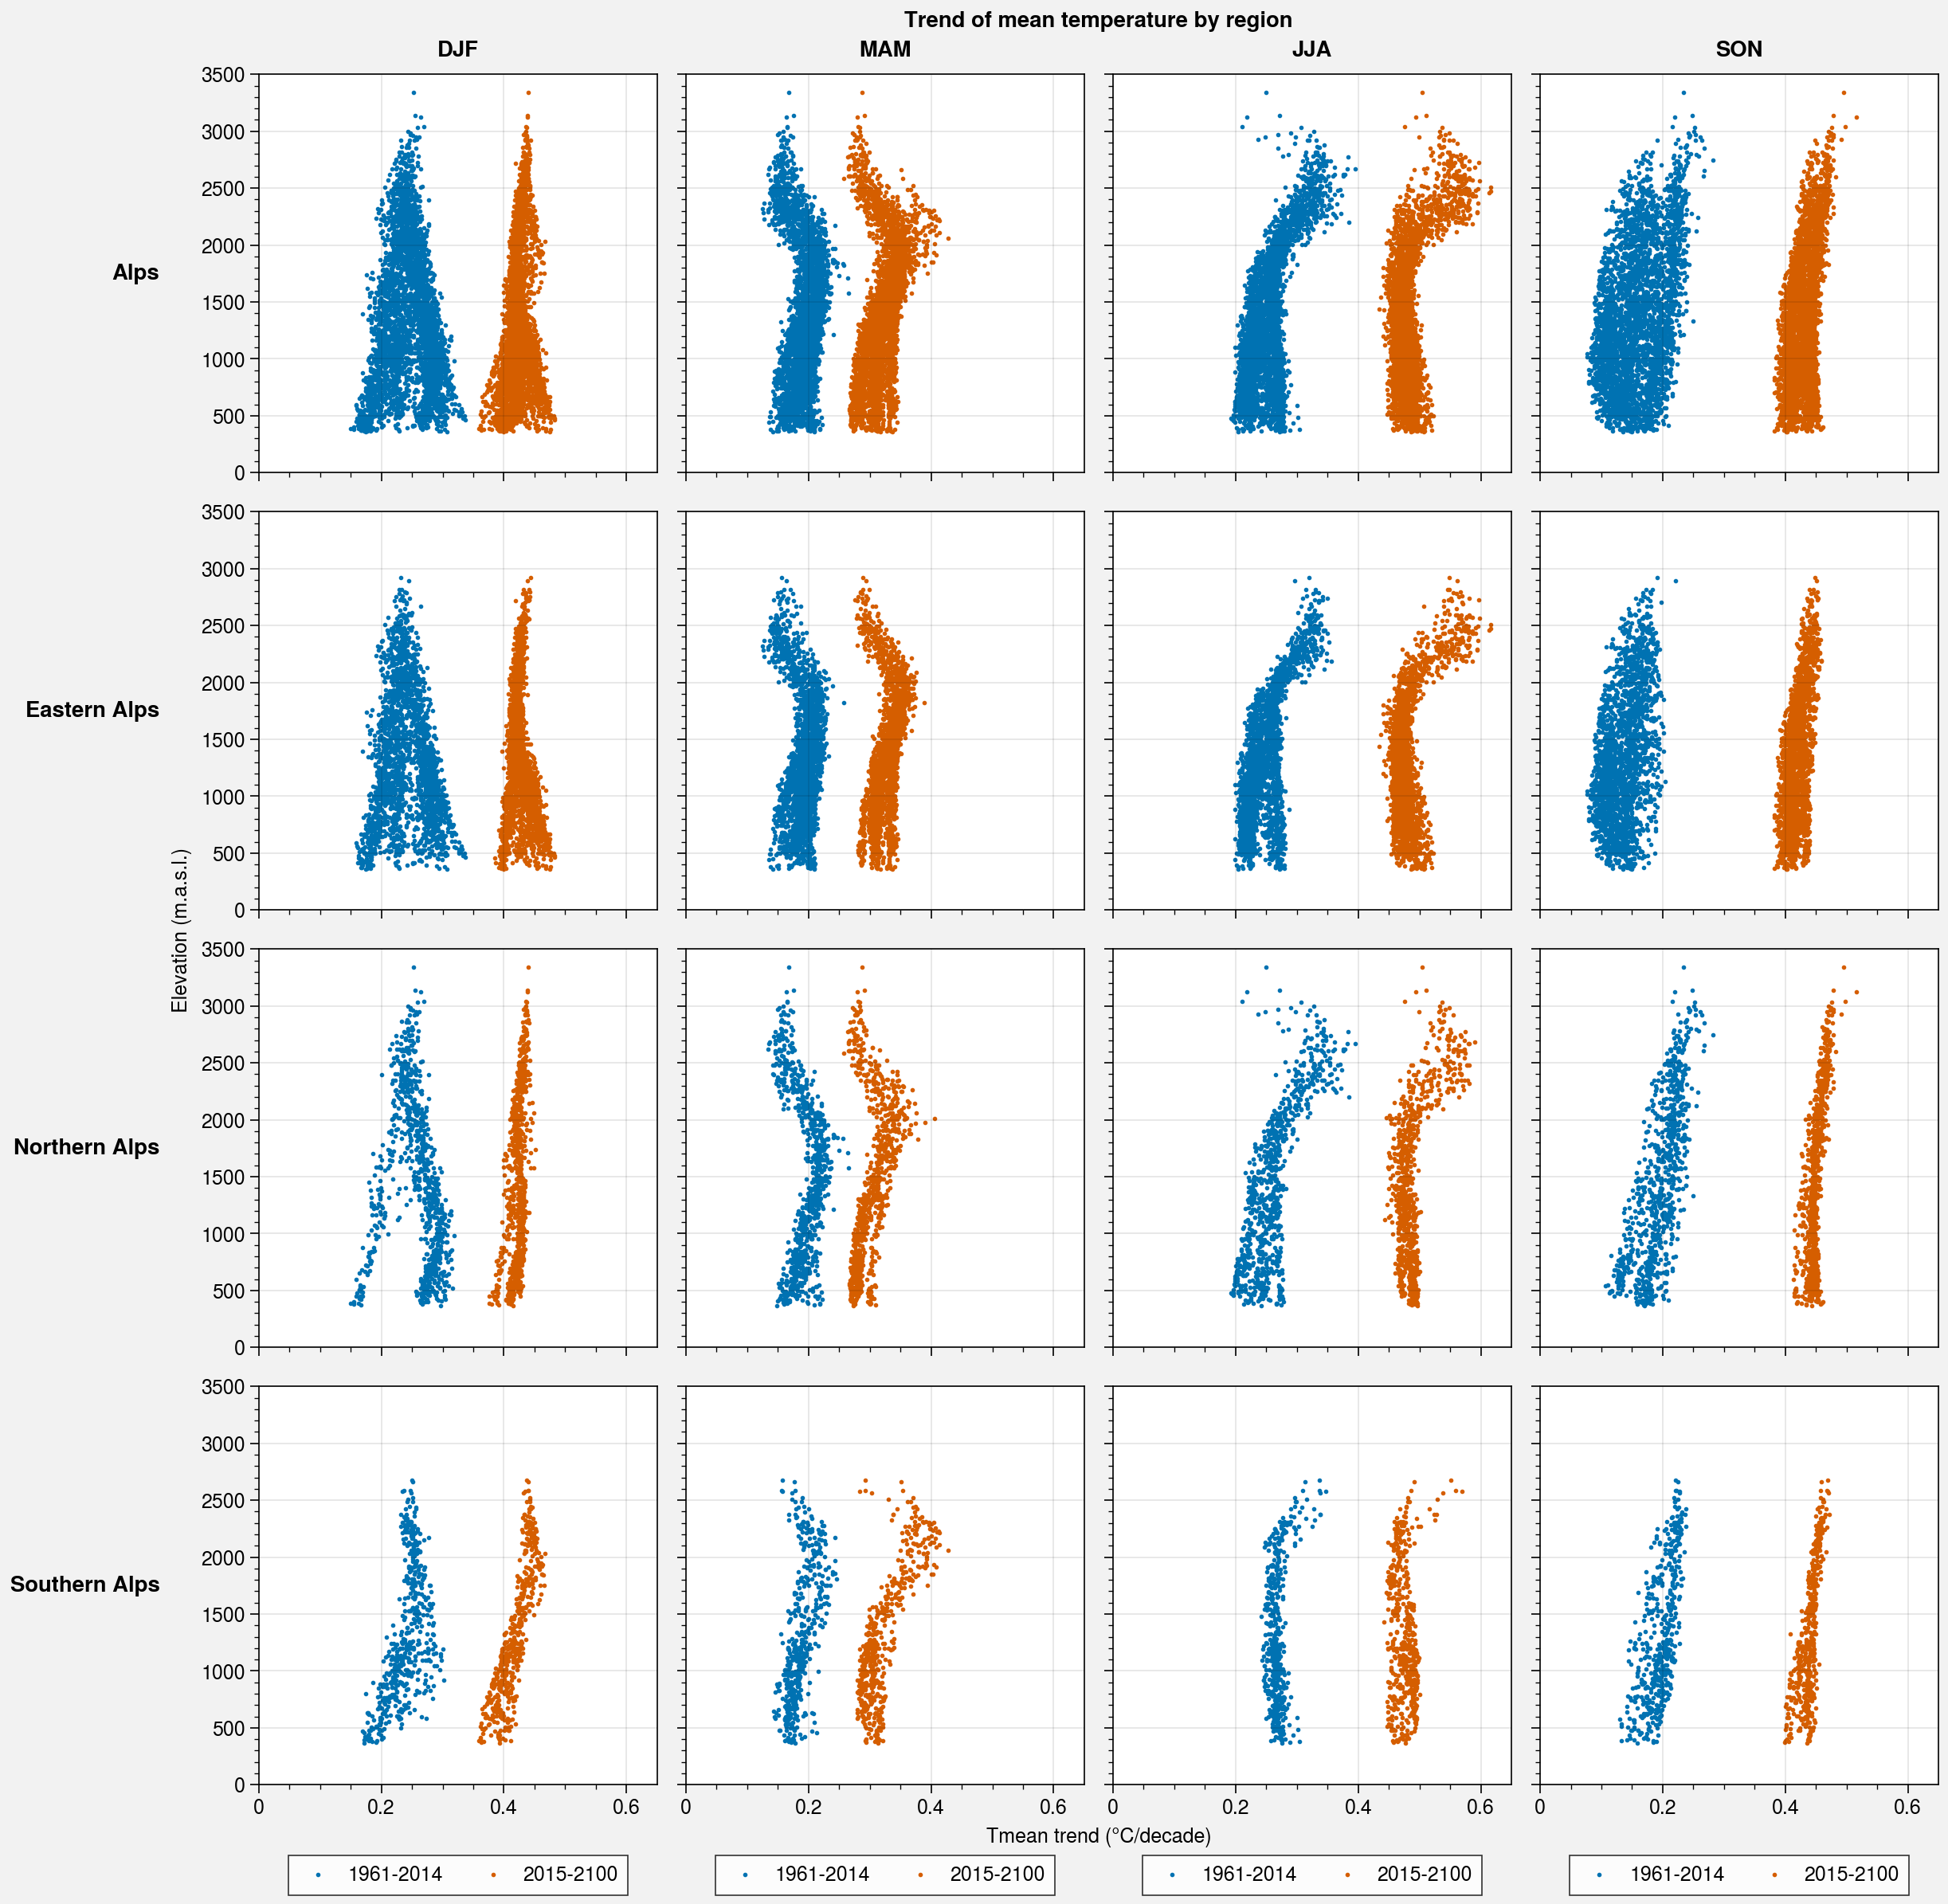

In [6]:
f, axs = pplt.subplots(ncols=4, nrows=4)
leg = ['1961-2014','2015-2100']

for i in range(4):
    slope_T_hist_alps = np.ma.masked_array(slope_T_hist[i], mask=np.invert(alps))
    slope_T_hist_east_alps = np.ma.masked_array(slope_T_hist[i], mask=np.invert(east_alps))
    slope_T_hist_north_alps = np.ma.masked_array(slope_T_hist[i], mask=np.invert(north_alps))
    slope_T_hist_south_alps = np.ma.masked_array(slope_T_hist[i], mask=np.invert(south_alps))
    slopes=[slope_T_hist_alps,slope_T_hist_east_alps,slope_T_hist_north_alps,slope_T_hist_south_alps]
    
    for j,slope in enumerate(slopes):
        ax = axs[i+4*j]
        blue_dot = ax.scatter(10*slope,ds.SH[jmin:jmax,imin:imax],s=2)
        
    
for i in range(4):
    slope_T_fut_alps = np.ma.masked_array(slope_T_fut[i], mask=np.invert(alps))
    slope_T_fut_east_alps = np.ma.masked_array(slope_T_fut[i], mask=np.invert(east_alps))
    slope_T_fut_north_alps = np.ma.masked_array(slope_T_fut[i], mask=np.invert(north_alps))
    slope_T_fut_south_alps = np.ma.masked_array(slope_T_fut[i], mask=np.invert(south_alps))
    slopes=[slope_T_fut_alps,slope_T_fut_east_alps,slope_T_fut_north_alps,slope_T_fut_south_alps]
    
    for j,slope in enumerate(slopes):
        ax = axs[i+4*j]
        orange_dot = ax.scatter(10*slope,ds.SH[jmin:jmax,imin:imax],s=2)
        ax.set_xlim((0.,0.65))
        ax.set_ylim((0.,3500))
        if(j==3):
            ax.legend([blue_dot,orange_dot],leg,loc='bottom')

axs.format(suptitle='Trend of mean temperature by region',collabels=['DJF','MAM','JJA', 'SON'],
           rowlabels=['Alps','Eastern Alps','Northern Alps','Southern Alps'],xlabel='Tmean trend (°C/decade)',ylabel='Elevation (m.a.s.l.)')

#### Spring, future period, entire Alps

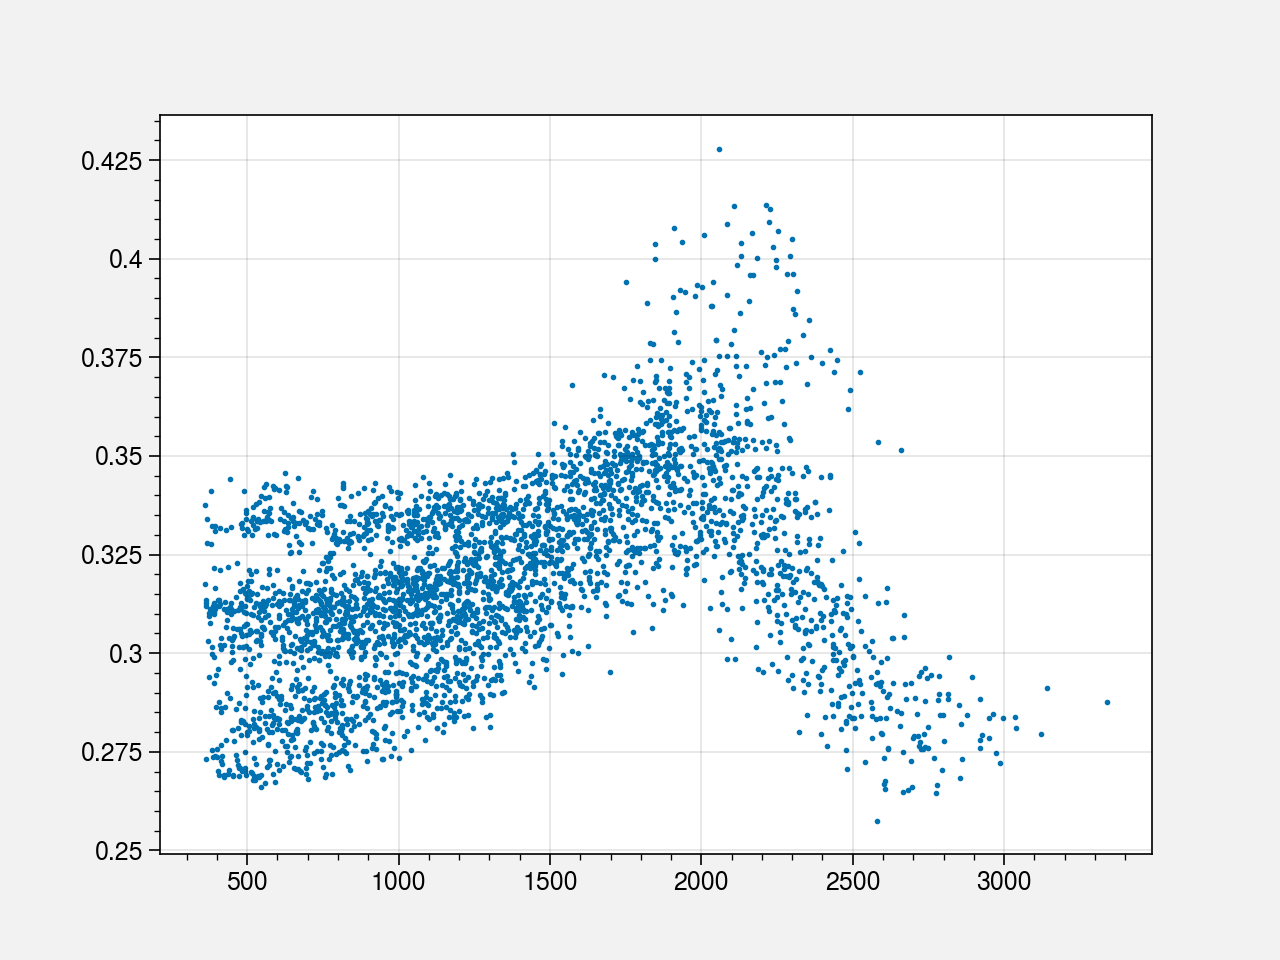

In [36]:
slope_T_MAM_fut_alps = 10*np.ma.masked_array(slope_T_fut[1], mask=np.invert(alps))
height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(alps))

plt.scatter(height,slope_T_MAM_fut_alps,s=2)

In [37]:
from scipy import interpolate

vec_slope_T_MAM_fut_alps = slope_T_MAM_fut_alps[slope_T_MAM_fut_alps.mask == False]
vec_height = height[height.mask == False]

vec_slope_T_MAM_fut_alps_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM_fut_alps), key=lambda pair: pair[0])]
vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM_fut_alps), key=lambda pair: pair[0])]


In [38]:
def spline(knots, x, y):
    x_new = np.linspace(0, 1, knots+2)[1:-1]
    q_knots = np.quantile(x, x_new)
    t, c, k = interpolate.splrep(x, y, t=q_knots)
    yfit = interpolate.BSpline(t,c, k)(x)
    return yfit

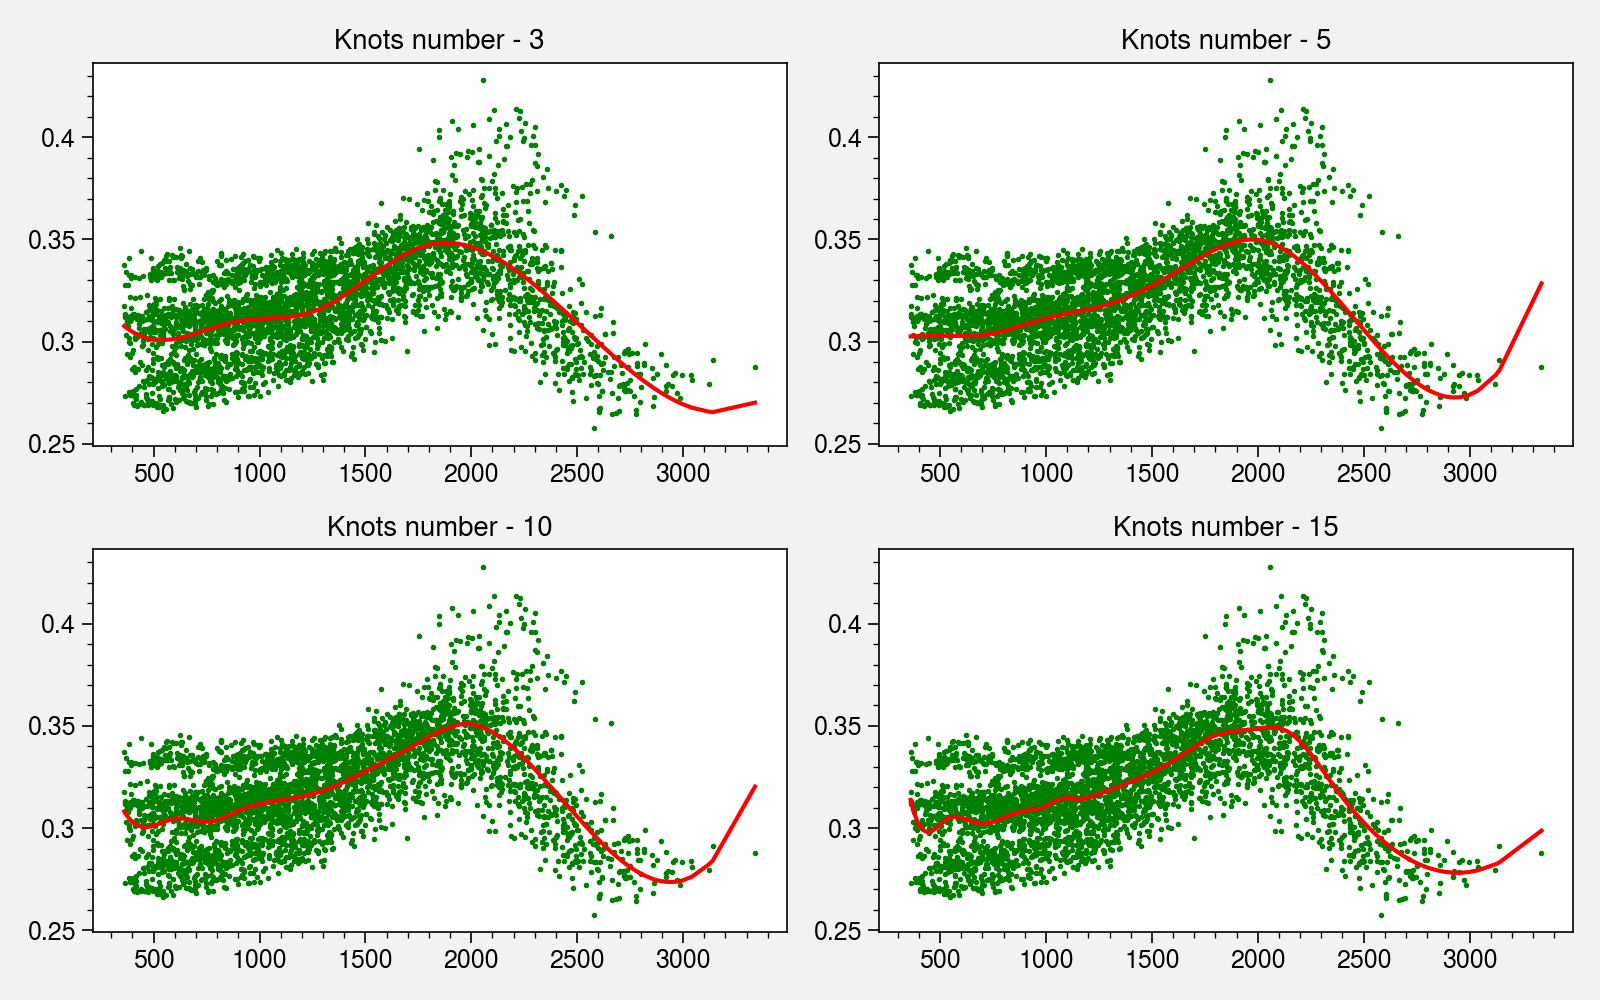

In [10]:
knots = [3, 5, 10, 15]
i = 0

ig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

 

for row in range(2):
    for col in range(2):
        ax[row][col].plot(vec_height_srt, vec_slope_T_MAM_fut_alps_srt, '.',c="g", markersize=2)
        yfit = spline(knots[i],vec_height_srt, vec_slope_T_MAM_fut_alps_srt)
        ax[row][col].plot(vec_height_srt, yfit, 'r')
        ax[row][col].set_title("Knots number - "+str(knots[i]))
        ax[row][col].grid()
        i=i+1
        
plt.tight_layout()        
plt.show() 

In [11]:
knot_numbers = 10
height_new = np.linspace(0, 1, knot_numbers+2)[1:-1]
q_knots = np.quantile(vec_height_srt, height_new)

t,c,k = interpolate.splrep(vec_height_srt, vec_slope_T_MAM_fut_alps_srt, t=q_knots, s=1)
yfit = interpolate.BSpline(t,c,k)(vec_height_srt)

In [12]:
vec_height_srt[np.argmax(yfit)]

1976.5571

### Evolution of peak of warming

In [ ]:
wp_meanseason_meanT_hist.shape[1:4]

In [ ]:

slope_T_periods_50=np.full((90, 4, 91, 139),np.nan)

firstperiod_start = 1961
lastperiod_start = 2051

for year in np.arange(0,90):
    print(year,end=' ')
    endyear = year+50
    wp_meanseason_meanT_period = wp_meanseason_meanT[year:endyear,:,:,:]
    for i in range(wp_meanseason_meanT.shape[3]):
        # print(str(lon)+'/'+str(les_season_maxT.shape[3]),end=' ')
        for j in range(wp_meanseason_meanT.shape[2]):
            for season in range(4):
                linregress_T_hist = linregress(np.arange(wp_meanseason_meanT_period.shape[0]), wp_meanseason_meanT_period[:,season,j,i])
                slope_T_periods_50[year][season][j][i] = linregress_T_hist.slope


In [22]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/slope_T_30yearperiods.npy', slope_T_periods)

In [29]:
np.save('/bettik/castelli/data/saved_data_MAR_ECEarth3/slope_T_50yearperiods.npy', slope_T_periods_50)

In [26]:
slope_T_periods_50 = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/slope_T_50yearperiods.npy')

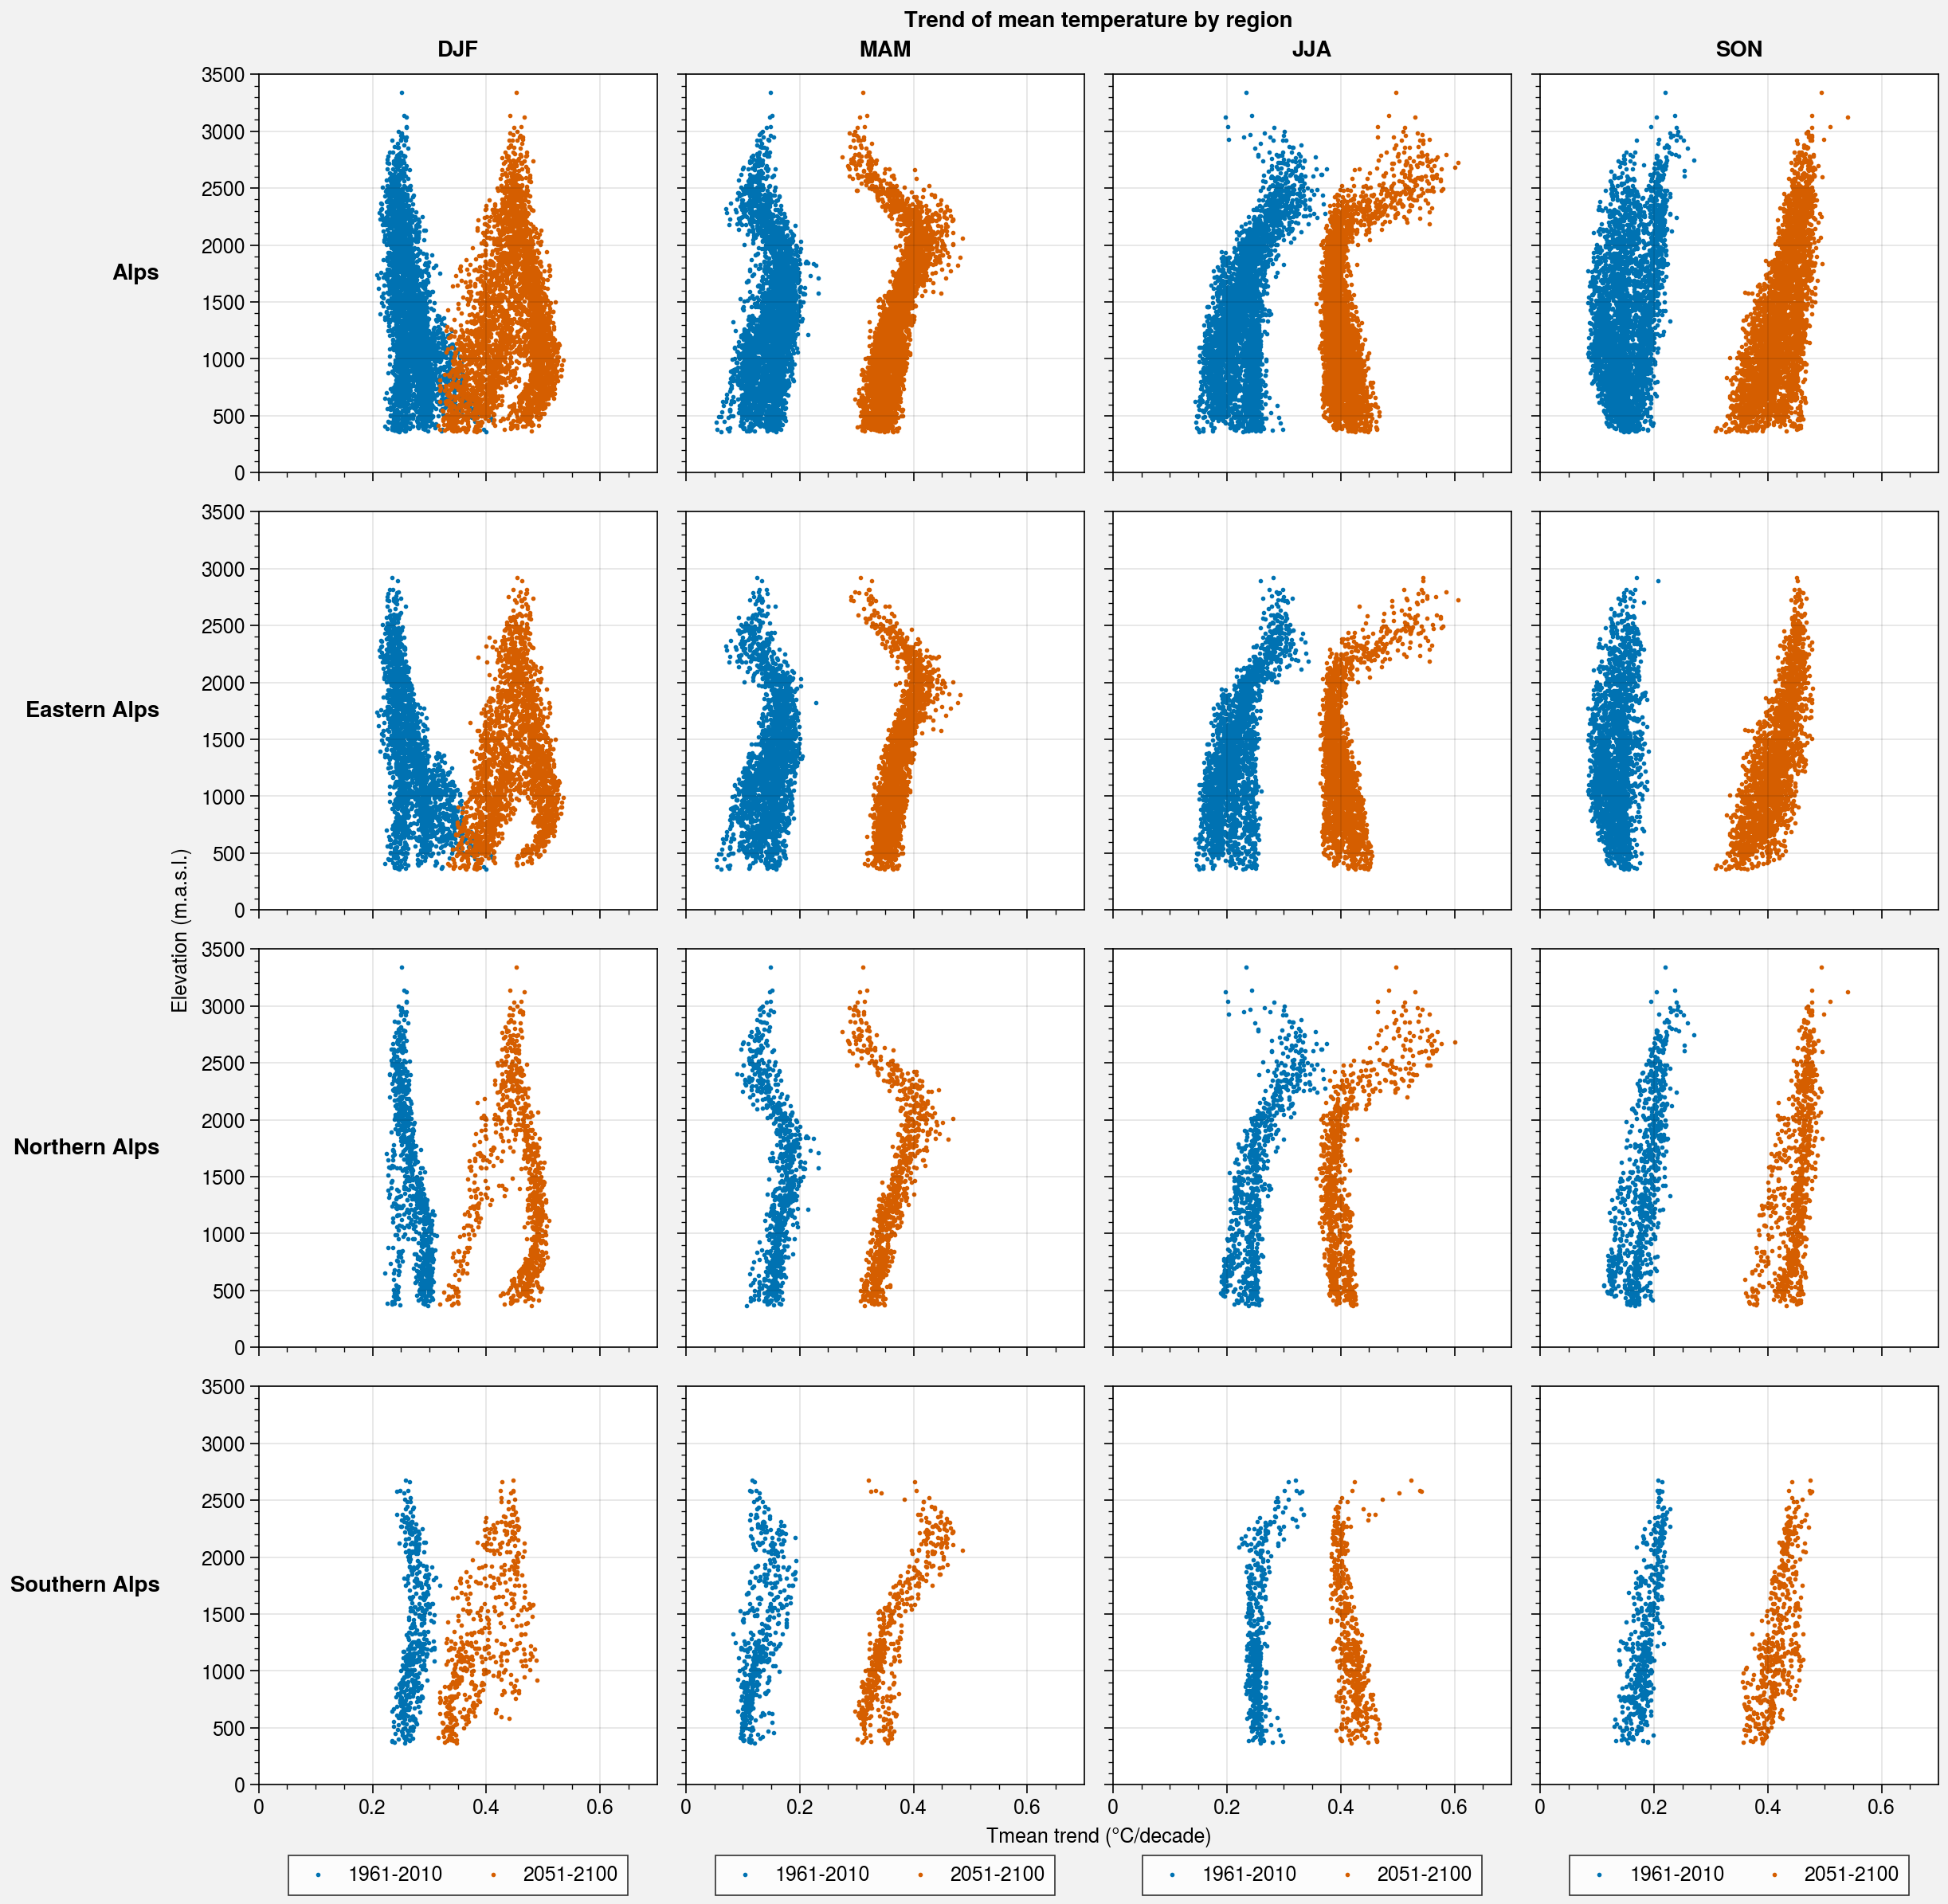

In [42]:
f, axs = pplt.subplots(ncols=4, nrows=4)
leg = ['1961-2010','2051-2100']

for i in range(4):
    slope_T_hist_alps = np.ma.masked_array(slope_T_periods_50[0,i], mask=np.invert(alps))
    slope_T_hist_east_alps = np.ma.masked_array(slope_T_periods_50[0,i], mask=np.invert(east_alps))
    slope_T_hist_north_alps = np.ma.masked_array(slope_T_periods_50[0,i], mask=np.invert(north_alps))
    slope_T_hist_south_alps = np.ma.masked_array(slope_T_periods_50[0,i], mask=np.invert(south_alps))
    slopes=[slope_T_hist_alps,slope_T_hist_east_alps,slope_T_hist_north_alps,slope_T_hist_south_alps]
    
    for j,slope in enumerate(slopes):
        ax = axs[i+4*j]
        blue_dot = ax.scatter(10*slope,ds.SH[jmin:jmax,imin:imax],s=2)
        
    
for i in range(4):
    slope_T_fut_alps = np.ma.masked_array(slope_T_periods_50[-1,i], mask=np.invert(alps))
    slope_T_fut_east_alps = np.ma.masked_array(slope_T_periods_50[-1,i], mask=np.invert(east_alps))
    slope_T_fut_north_alps = np.ma.masked_array(slope_T_periods_50[-1,i], mask=np.invert(north_alps))
    slope_T_fut_south_alps = np.ma.masked_array(slope_T_periods_50[-1,i], mask=np.invert(south_alps))
    slopes=[slope_T_fut_alps,slope_T_fut_east_alps,slope_T_fut_north_alps,slope_T_fut_south_alps]
    
    for j,slope in enumerate(slopes):
        ax = axs[i+4*j]
        orange_dot = ax.scatter(10*slope,ds.SH[jmin:jmax,imin:imax],s=2)
        ax.set_xlim((0.,0.7))
        ax.set_ylim((0.,3500))
        if(j==3):
            ax.legend([blue_dot,orange_dot],leg,loc='bottom')

axs.format(suptitle='Trend of mean temperature by region',collabels=['DJF','MAM','JJA', 'SON'],
           rowlabels=['Alps','Eastern Alps','Northern Alps','Southern Alps'],xlabel='Tmean trend (°C/decade)',ylabel='Elevation (m.a.s.l.)')

In [27]:

knot_numbers = 10
height_new = np.linspace(0, 1, knot_numbers+2)[1:-1]


height_max = np.full((4,90),np.nan) # 4 regions, 90 periods

alps_masks = [alps, east_alps, north_alps, south_alps]

for region in range(4):
    height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(alps_masks[region]))
    vec_height = height[height.mask == False]
    for i in range(90):
        slope_T_MAM = 10*np.ma.masked_array(slope_T_periods_50[i,1], mask=np.invert(alps_masks[region]))
        vec_slope_T_MAM = slope_T_MAM[slope_T_MAM.mask == False]
        
        vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
        vec_slope_T_MAM_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
        
        q_knots = np.quantile(vec_height_srt, height_new)
        
        t,c,k = interpolate.splrep(vec_height_srt, vec_slope_T_MAM_srt, t=q_knots, s=1)
        yfit = interpolate.BSpline(t,c,k)(vec_height_srt)
        
        height_max[region,i] = vec_height_srt[np.argmax(yfit)]

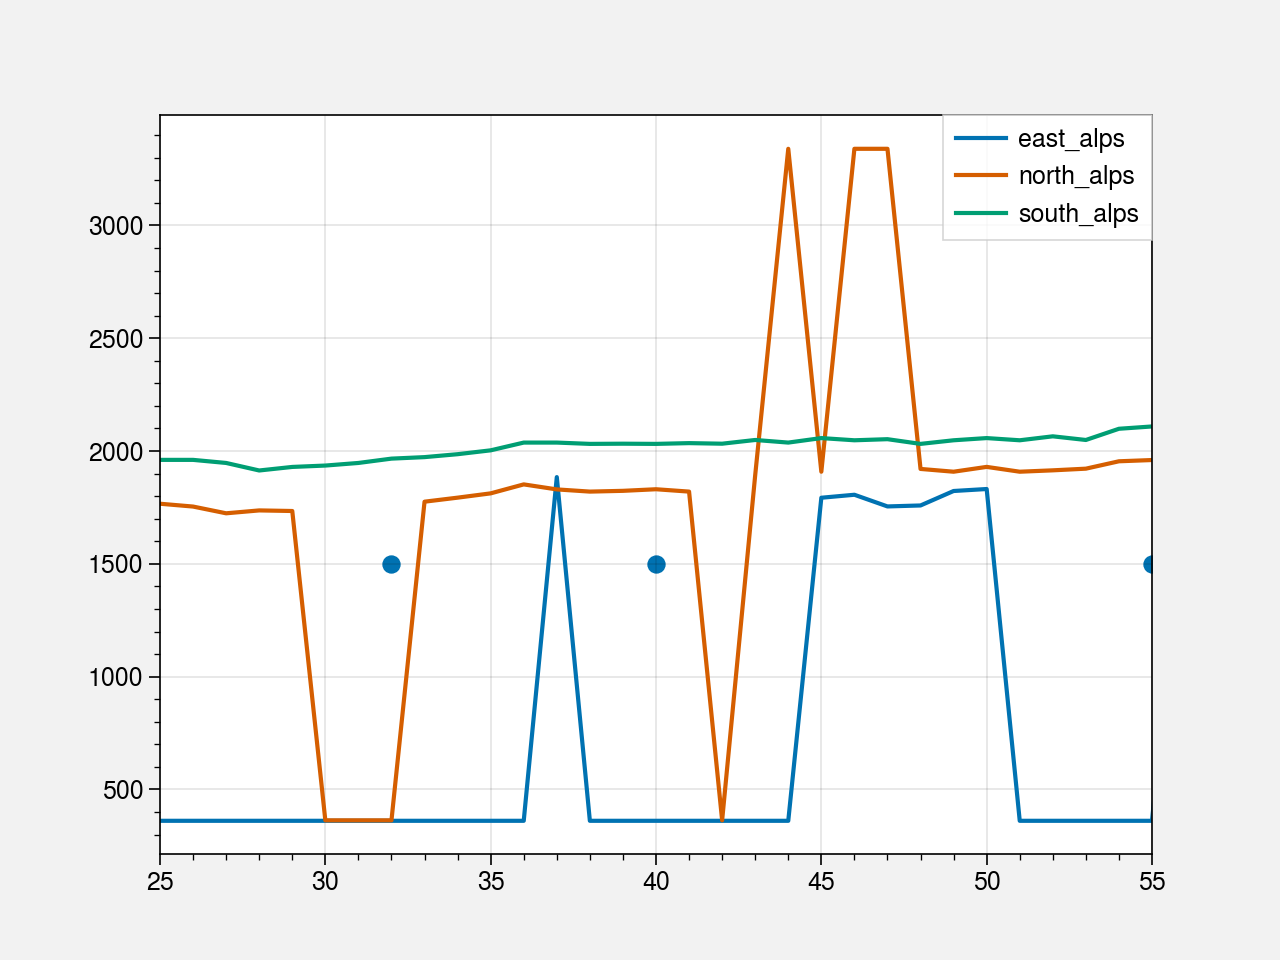

In [28]:
#plt.plot(height_max[0],label='alps')
plt.plot(height_max[1],label='east_alps')
plt.plot(height_max[2],label='north_alps')
plt.plot(height_max[3],label='south_alps')
plt.scatter((21,32,40,55),(1500,1500,1500,1500))
plt.xlim(25,55)
plt.legend()

In [18]:

knot_numbers = 5
height_new = np.linspace(0, 1, knot_numbers+2)[1:-1]


height_max = np.full((4,90),np.nan) # 4 regions, 90 periods

alps_masks = [alps, east_alps, north_alps, south_alps]

for region in range(4):
    height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(alps_masks[region]))
    vec_height = height[height.mask == False]
    for i in range(90):
        slope_T_MAM = 10*np.ma.masked_array(slope_T_periods_50[i,1], mask=np.invert(alps_masks[region]))
        vec_slope_T_MAM = slope_T_MAM[slope_T_MAM.mask == False]
        
        vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
        vec_slope_T_MAM_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
        
        q_knots = np.quantile(vec_height_srt, height_new)
        
        t,c,k = interpolate.splrep(vec_height_srt, vec_slope_T_MAM_srt, t=q_knots, s=1)
        yfit = interpolate.BSpline(t,c,k)(vec_height_srt)
        
        height_max[region,i] = vec_height_srt[np.argmax(yfit)]

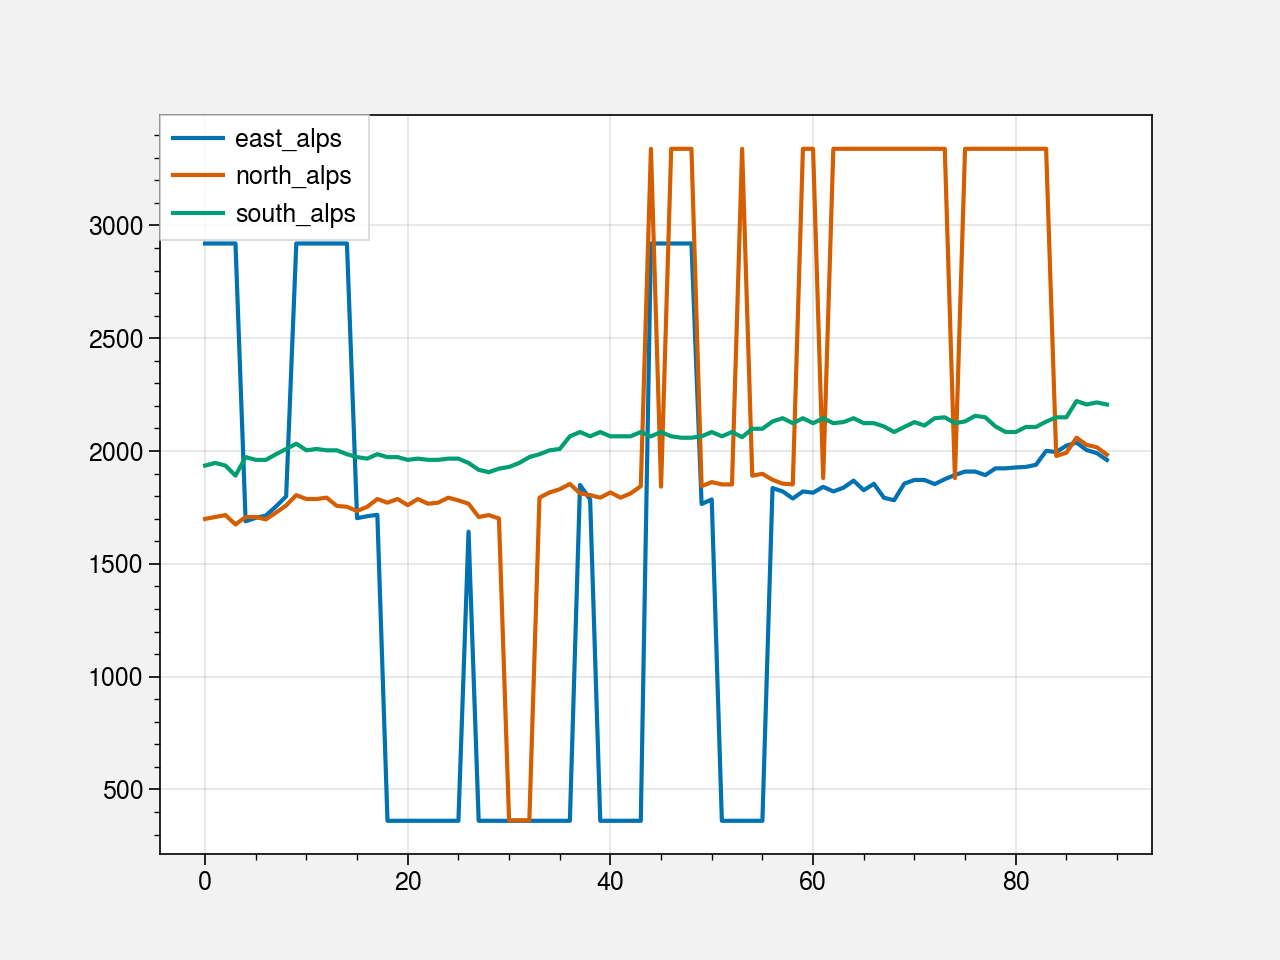

In [19]:
#plt.plot(height_max[0],label='alps')
plt.plot(height_max[1],label='east_alps')
plt.plot(height_max[2],label='north_alps')
plt.plot(height_max[3],label='south_alps')
plt.legend()

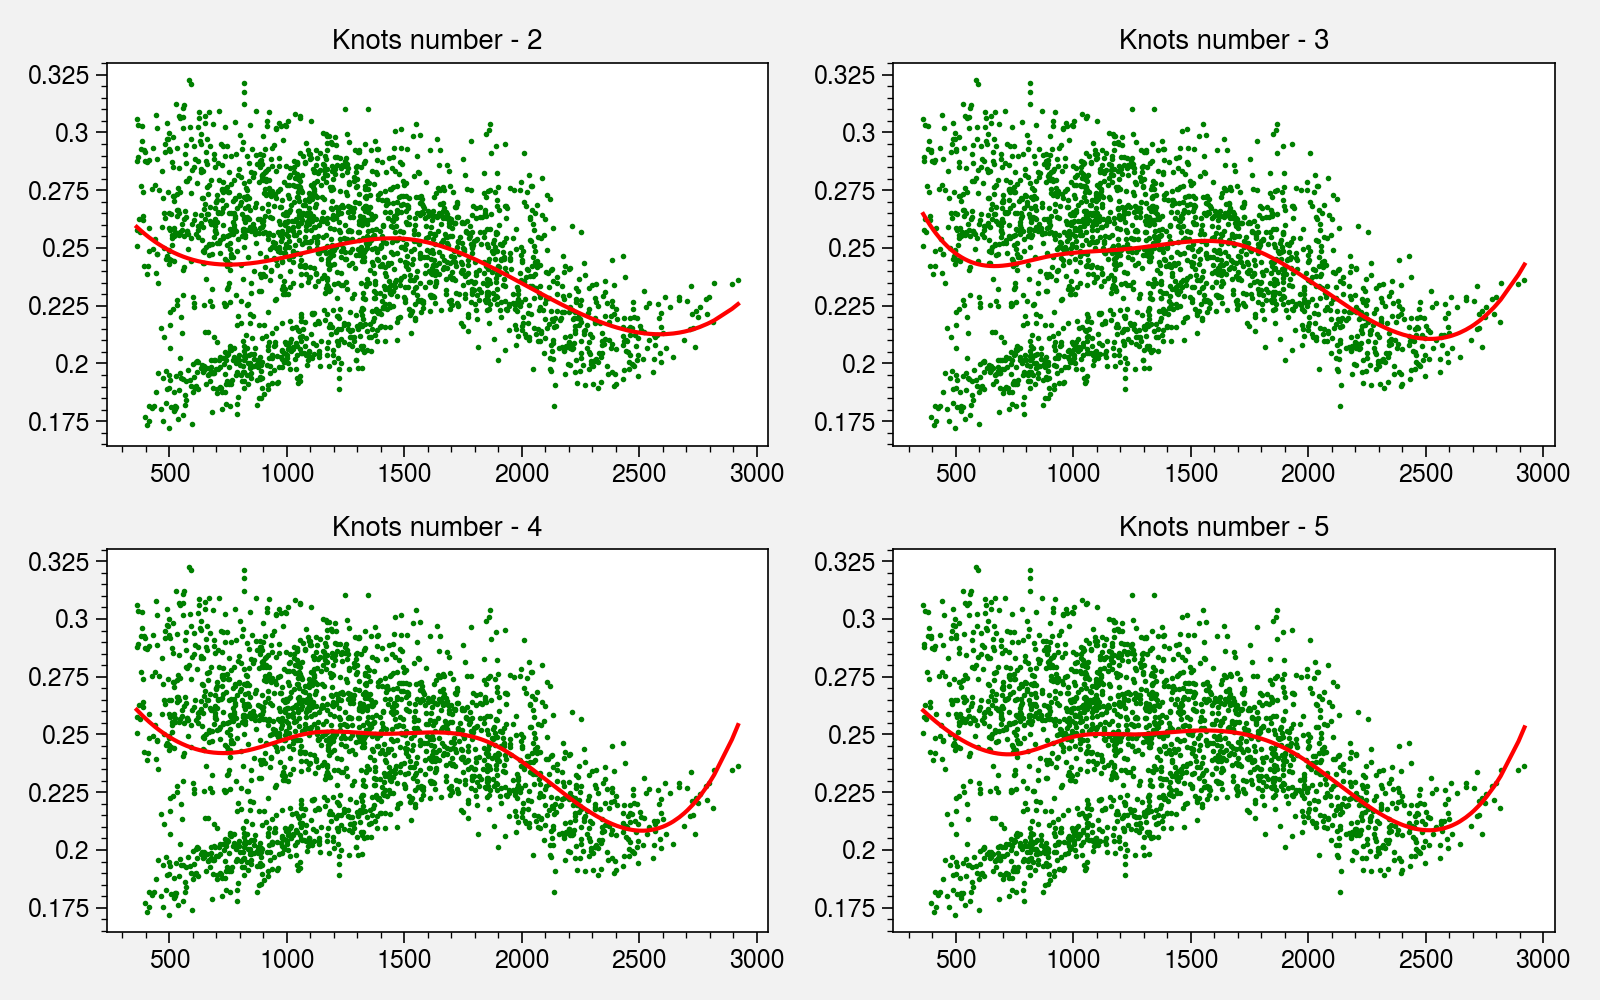

In [20]:
i=21

height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(alps_masks[1]))
vec_height = height[height.mask == False]

slope_T_MAM = 10*np.ma.masked_array(slope_T_periods_50[i,1], mask=np.invert(alps_masks[1]))
vec_slope_T_MAM = slope_T_MAM[slope_T_MAM.mask == False]
        
vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
vec_slope_T_MAM_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]


knots = [2, 3, 4, 5]
i = 0

ig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

for row in range(2):
    for col in range(2):
        ax[row][col].plot(vec_height_srt, vec_slope_T_MAM_srt, '.',c="g", markersize=2)
        yfit = spline(knots[i],vec_height_srt, vec_slope_T_MAM_srt)
        ax[row][col].plot(vec_height_srt, yfit, 'r')
        ax[row][col].set_title("Knots number - "+str(knots[i]))
        ax[row][col].grid()
        i=i+1
        
plt.tight_layout()        
plt.show()

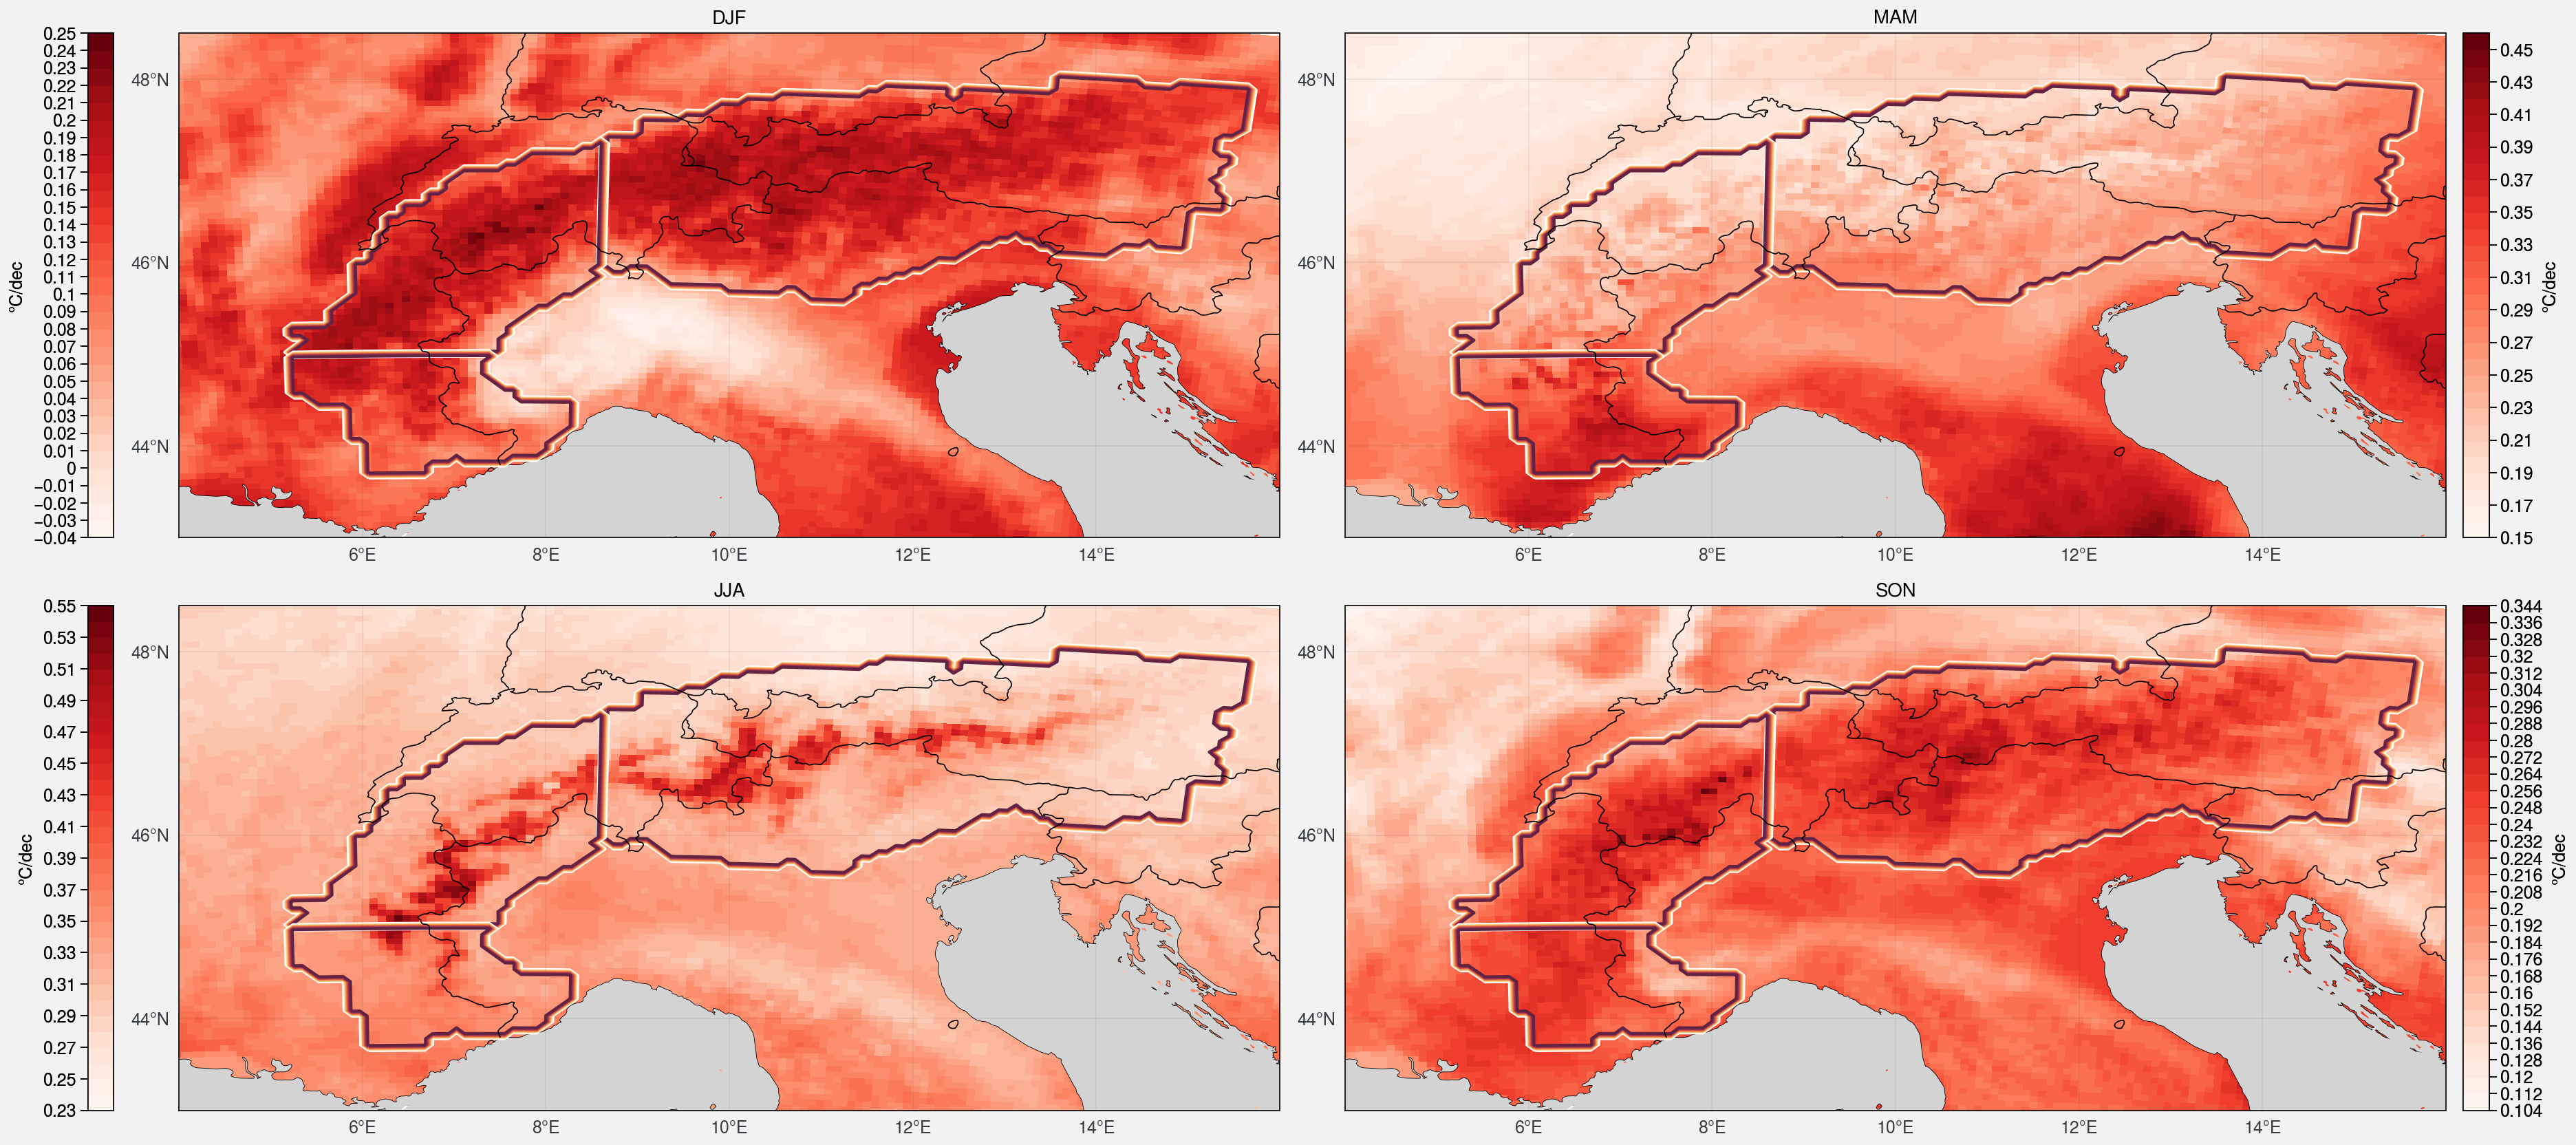

In [35]:
i = 21

slope = 10*slope_T_periods_50[i]

f, axs = pplt.subplots(proj='cyl', ncols=2, nrows=2, axwidth=8,share=False)

m=axs[0].pcolormesh(lon, lat, slope[0], levels=33,cmap='Reds')
f.colorbar(m,label= '°C/dec',loc='l',row=1)#,col=1)
axs[0].contour(lon, lat,east_alps)
axs[0].contour(lon, lat,north_alps)
axs[0].contour(lon, lat,south_alps)
axs[0].format(**normal_format,title='DJF')
axs[0].format(ocean=True,oceancolor='lightgray',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])

m=axs[1].pcolormesh(lon, lat, slope[1], levels=33,cmap='Reds')
f.colorbar(m,label= '°C/dec',loc='r',row=1)#,col=2)
axs[1].contour(lon, lat,east_alps)
axs[1].contour(lon, lat,north_alps)
axs[1].contour(lon, lat,south_alps)
axs[1].format(**normal_format,title='MAM')
axs[1].format(ocean=True,oceancolor='lightgray',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])


m=axs[2].pcolormesh(lon, lat, slope[2], levels=33,cmap='Reds')
f.colorbar(m,label= '°C/dec',loc='l',row=2)#,col=1)
axs[2].contour(lon, lat,east_alps)
axs[2].contour(lon, lat,north_alps)
axs[2].contour(lon, lat,south_alps)
axs[2].format(**normal_format,title='JJA')
axs[2].format(ocean=True,oceancolor='lightgray',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])

m=axs[3].pcolormesh(lon, lat, slope[3], levels=33,cmap='Reds')
f.colorbar(m,label= '°C/dec',loc='r',row=2)#,col=2)
axs[3].contour(lon, lat,east_alps)
axs[3].contour(lon, lat,north_alps)
axs[3].contour(lon, lat,south_alps)
axs[3].format(**normal_format,title='SON')
axs[3].format(ocean=True,oceancolor='lightgray',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])

In [40]:
slope_T_periods_50.shape

(90, 4, 91, 139)

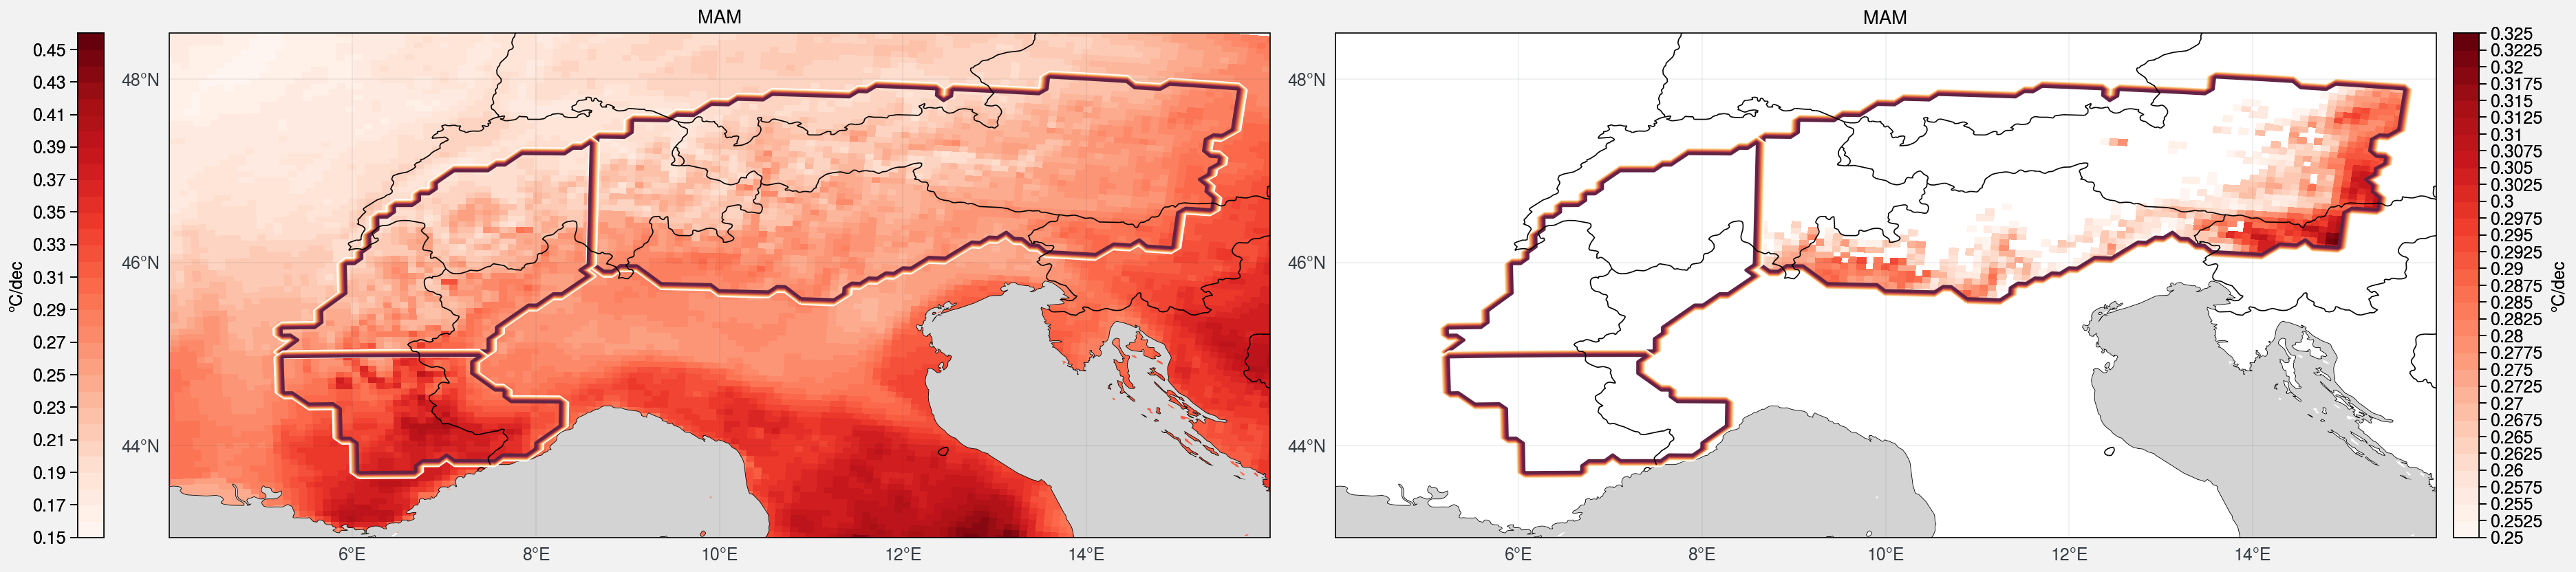

In [44]:
i = 21

slope = 10*slope_T_periods_50[i]

east_alps_low = np.logical_and(east_alps,H<1500)
east_alps_low_hot = np.logical_and(east_alps_low,slope[1]>0.25)

eastalps_slope_low_hot = np.ma.masked_array(slope[1], mask=np.invert(east_alps_low_hot))

f, axs = pplt.subplots(proj='cyl', ncols=2, axwidth=8)

m=axs[0].pcolormesh(lon, lat, slope[1], levels=33,cmap='Reds')
f.colorbar(m,label= '°C/dec',loc='l')
axs[0].contour(lon, lat,east_alps)
axs[0].contour(lon, lat,north_alps)
axs[0].contour(lon, lat,south_alps)
axs[0].format(**normal_format,title='MAM')
axs[0].format(ocean=True,oceancolor='lightgray',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])


m=axs[1].pcolormesh(lon, lat, eastalps_slope_low_hot, levels=33,cmap='Reds')
f.colorbar(m,label= '°C/dec',loc='r')
axs[1].contour(lon, lat,east_alps)
axs[1].contour(lon, lat,north_alps)
axs[1].contour(lon, lat,south_alps)
axs[1].format(**normal_format,title='MAM')
axs[1].format(ocean=True,oceancolor='lightgray',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])

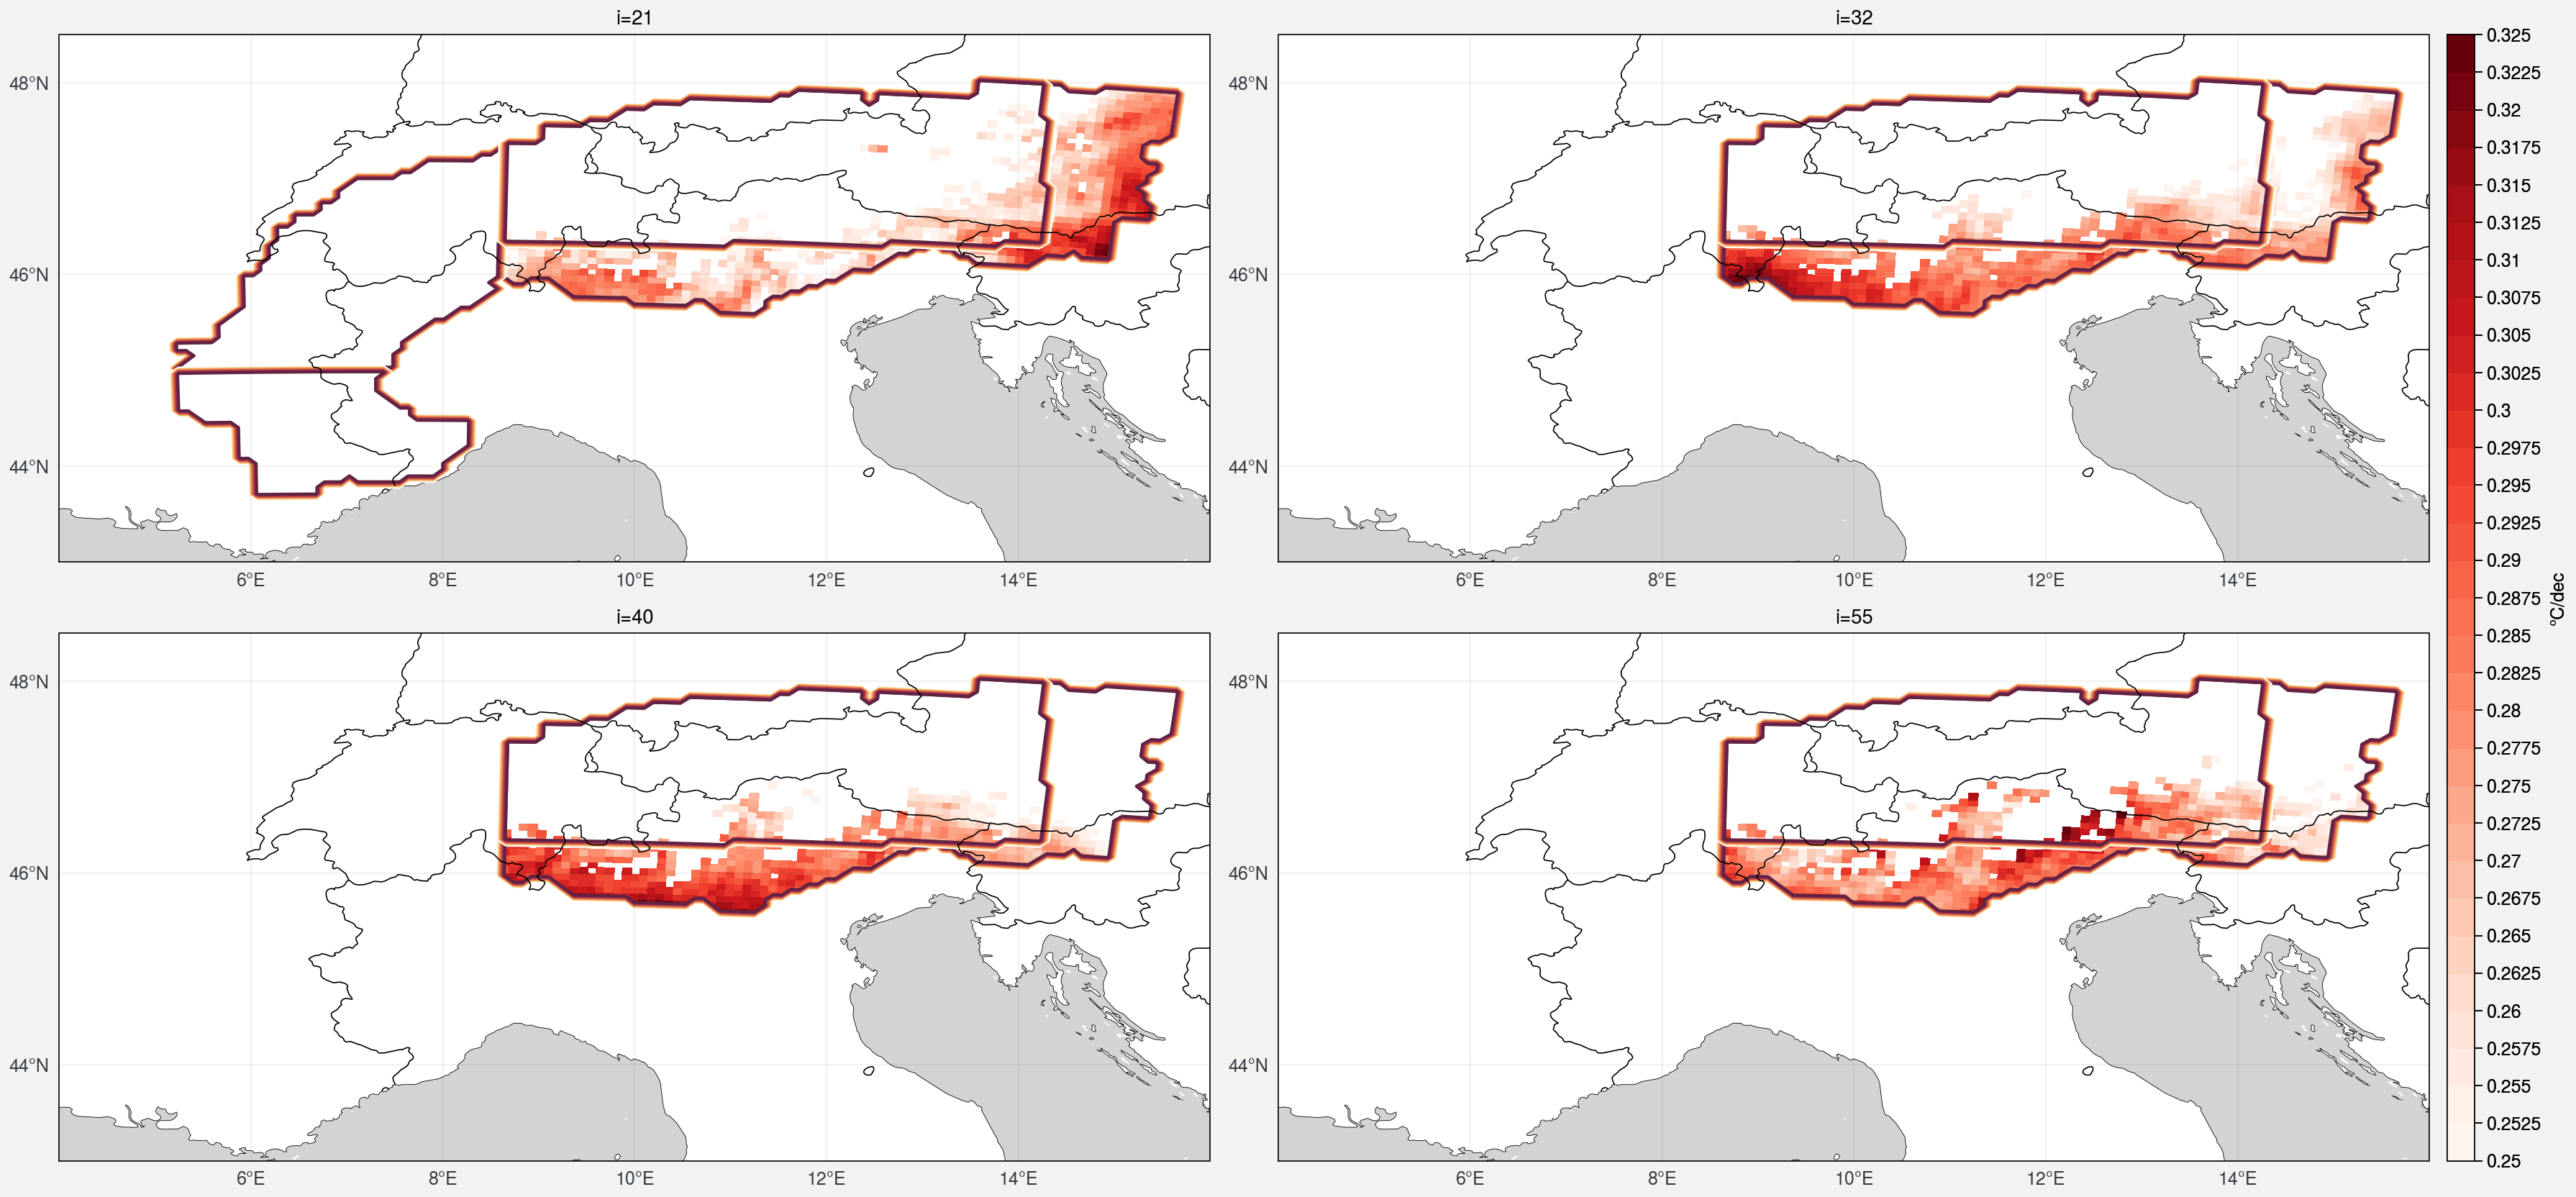

In [34]:
f, axs = pplt.subplots(proj='cyl', ncols=2, nrows=2, axwidth=8)

i = 21
slope = 10*slope_T_periods_50[i]
east_alps_low = np.logical_and(east_alps,H<1500)
east_alps_low_hot = np.logical_and(east_alps_low,slope[1]>0.25)
eastalps_slope_low_hot = np.ma.masked_array(slope[1], mask=np.invert(east_alps_low_hot))
m=axs[0].pcolormesh(lon, lat, eastalps_slope_low_hot, levels=33,cmap='Reds')
f.colorbar(m,label= '°C/dec')
axs[0].contour(lon, lat,east_alps)
axs[0].contour(lon, lat,north_alps)
axs[0].contour(lon, lat,south_alps)
axs[0].contour(lon, lat,cn_alps)
axs[0].format(**normal_format,title='i=21')
axs[0].format(ocean=True,oceancolor='lightgray',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])


i = 32
slope = 10*slope_T_periods_50[i]
east_alps_low = np.logical_and(east_alps,H<1500)
east_alps_low_hot = np.logical_and(east_alps_low,slope[1]>0.15)
eastalps_slope_low_hot = np.ma.masked_array(slope[1], mask=np.invert(east_alps_low_hot))
m=axs[1].pcolormesh(lon, lat, eastalps_slope_low_hot, levels=33,cmap='Reds')
axs[1].contour(lon, lat,east_alps)
axs[1].contour(lon, lat,cn_alps)
axs[1].format(**normal_format,title='i=32')
axs[1].format(ocean=True,oceancolor='lightgray',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])


i = 40
slope = 10*slope_T_periods_50[i]
east_alps_low = np.logical_and(east_alps,H<1500)
east_alps_low_hot = np.logical_and(east_alps_low,slope[1]>0.28)
eastalps_slope_low_hot = np.ma.masked_array(slope[1], mask=np.invert(east_alps_low_hot))
m=axs[2].pcolormesh(lon, lat, eastalps_slope_low_hot, levels=33,cmap='Reds')
axs[2].contour(lon, lat,east_alps)
axs[2].contour(lon, lat,cn_alps)
axs[2].format(**normal_format,title='i=40')
axs[2].format(ocean=True,oceancolor='lightgray',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])


i = 55
slope = 10*slope_T_periods_50[i]
east_alps_low = np.logical_and(east_alps,H<1500)
east_alps_low_hot = np.logical_and(east_alps_low,slope[1]>0.27)
eastalps_slope_low_hot = np.ma.masked_array(slope[1], mask=np.invert(east_alps_low_hot))
m=axs[3].pcolormesh(lon, lat, eastalps_slope_low_hot, levels=33,cmap='Reds')
axs[3].contour(lon, lat,east_alps)
axs[3].contour(lon, lat,cn_alps)
axs[3].format(**normal_format,title='i=55')
axs[3].format(ocean=True,oceancolor='lightgray',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])

#### Let's try with a definition of center-north Alps

In [60]:

knot_numbers = 10
height_new = np.linspace(0, 1, knot_numbers+2)[1:-1]


height_max = np.full((5,90),np.nan) # 4 regions, 90 periods

alps_masks = [alps, east_alps, north_alps, south_alps, cn_alps]

for region in range(5):
    height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(alps_masks[region]))
    vec_height = height[height.mask == False]
    for i in range(90):
        slope_T_MAM = 10*np.ma.masked_array(slope_T_periods_50[i,1], mask=np.invert(alps_masks[region]))
        vec_slope_T_MAM = slope_T_MAM[slope_T_MAM.mask == False]
        
        vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
        vec_slope_T_MAM_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
        
        q_knots = np.quantile(vec_height_srt, height_new)
        
        t,c,k = interpolate.splrep(vec_height_srt, vec_slope_T_MAM_srt, t=q_knots, s=1)
        yfit = interpolate.BSpline(t,c,k)(vec_height_srt)
        
        height_max[region,i] = vec_height_srt[np.argmax(yfit)]

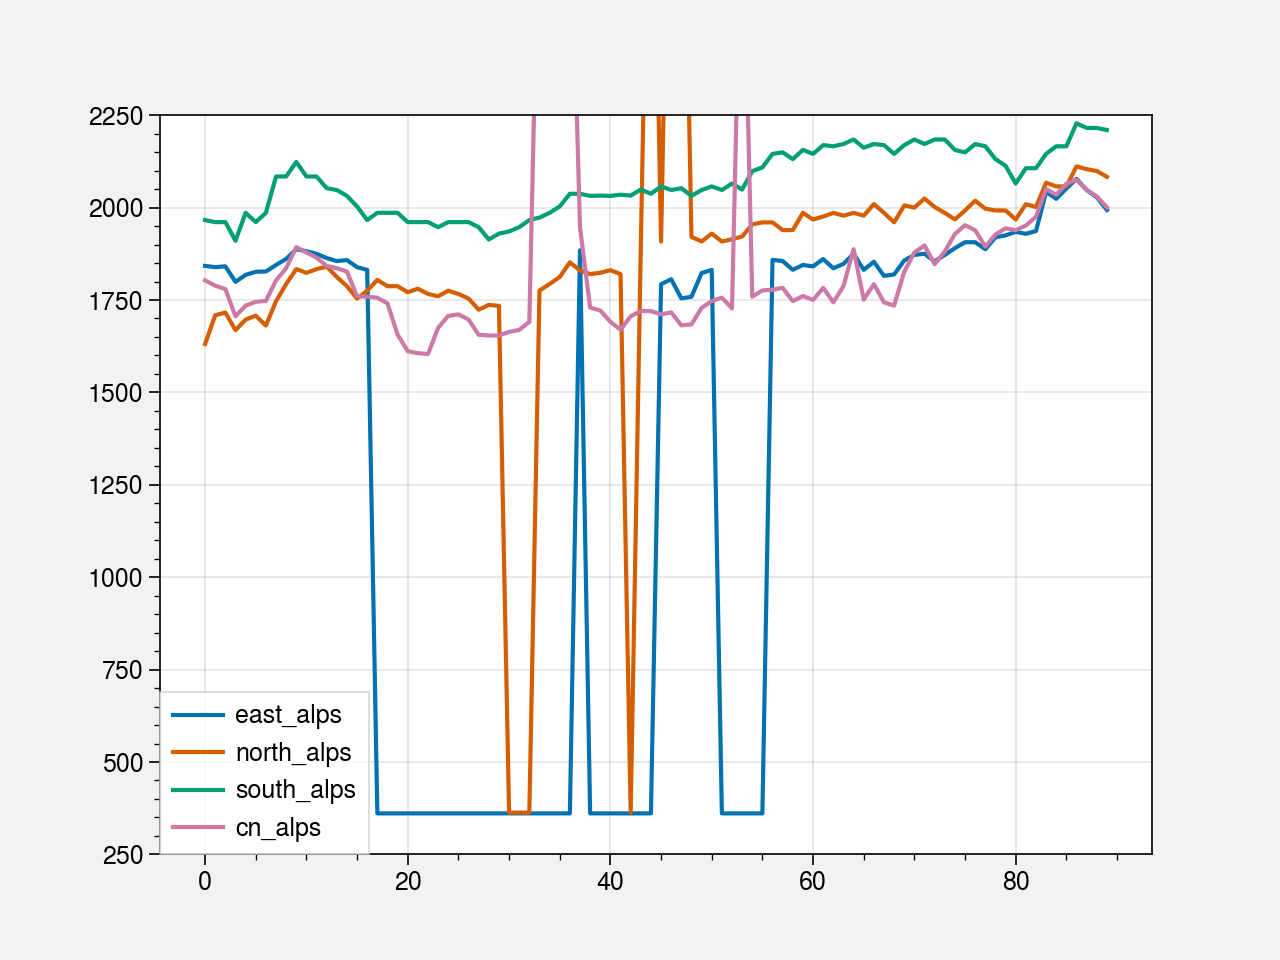

In [61]:
plt.plot(height_max[1],label='east_alps')
plt.plot(height_max[2],label='north_alps')
plt.plot(height_max[3],label='south_alps')
plt.plot(height_max[4],label='cn_alps')
plt.ylim(250,2250)
plt.legend()

In [62]:
knot_numbers = 9
height_new = np.linspace(0, 1, knot_numbers+2)[1:-1]


height_max = np.full((5,90),np.nan) # 4 regions, 90 periods

alps_masks = [alps, east_alps, north_alps, south_alps, cn_alps]

for region in range(5):
    height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(alps_masks[region]))
    vec_height = height[height.mask == False]
    for i in range(90):
        slope_T_MAM = 10*np.ma.masked_array(slope_T_periods_50[i,1], mask=np.invert(alps_masks[region]))
        vec_slope_T_MAM = slope_T_MAM[slope_T_MAM.mask == False]
        
        vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
        vec_slope_T_MAM_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
        
        q_knots = np.quantile(vec_height_srt, height_new)
        
        t,c,k = interpolate.splrep(vec_height_srt, vec_slope_T_MAM_srt, t=q_knots, s=1)
        yfit = interpolate.BSpline(t,c,k)(vec_height_srt)
        
        if(region==2):
            height_max[region,i] = vec_height_srt[np.argmax(yfit[100:-50])]
        elif(region==4):
            height_max[region,i] = vec_height_srt[np.argmax(yfit[100:-100])]
        else:
            height_max[region,i] = vec_height_srt[np.argmax(yfit)]
        
    print(yfit.shape)

(3556,)
(2217,)
(839,)
(500,)
(1476,)


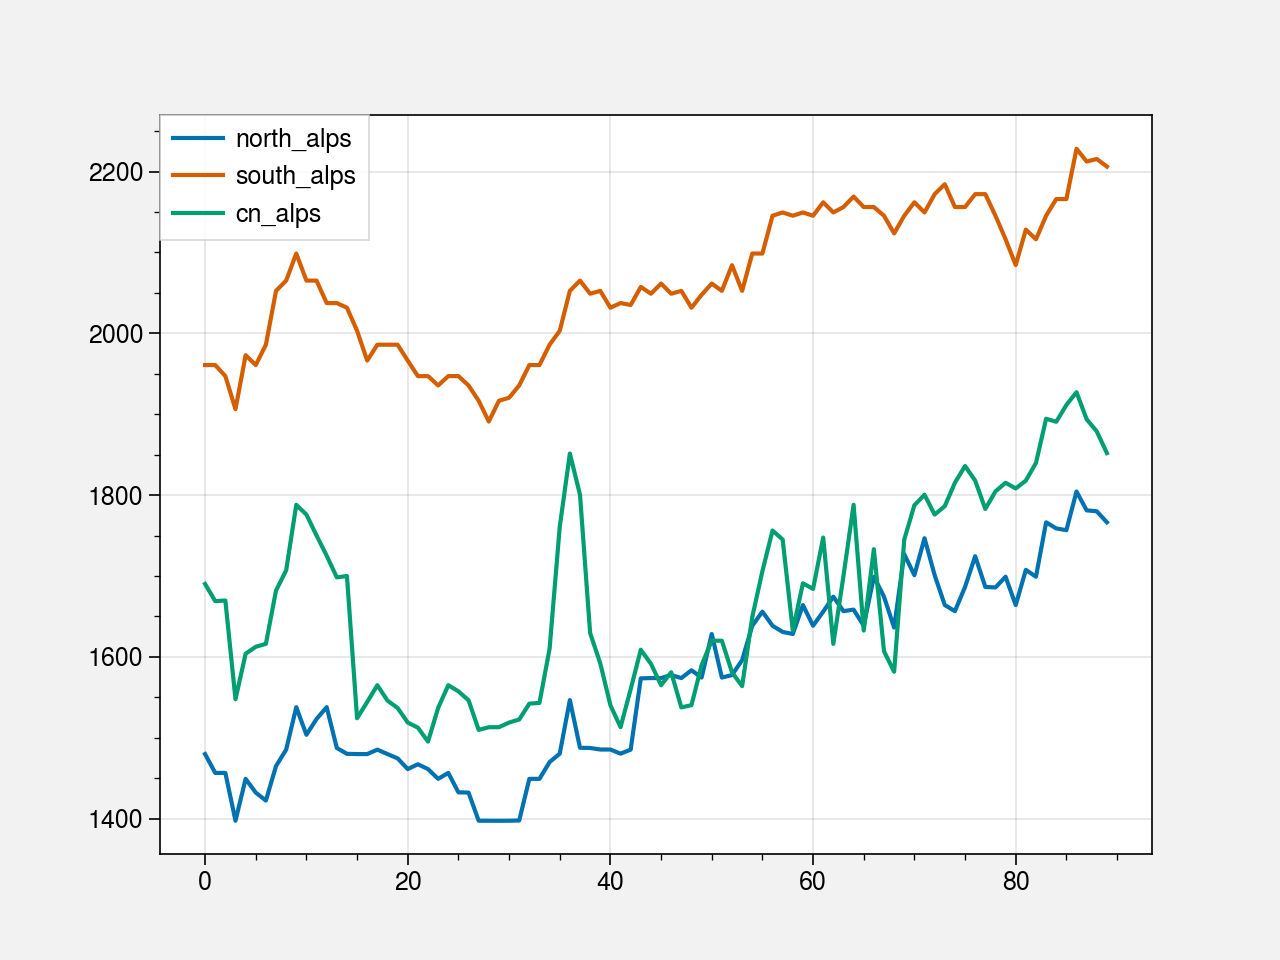

In [70]:
#plt.plot(height_max[1],label='east_alps')
plt.plot(height_max[2],label='north_alps')
plt.plot(height_max[3],label='south_alps')
plt.plot(height_max[4],label='cn_alps')
plt.legend()

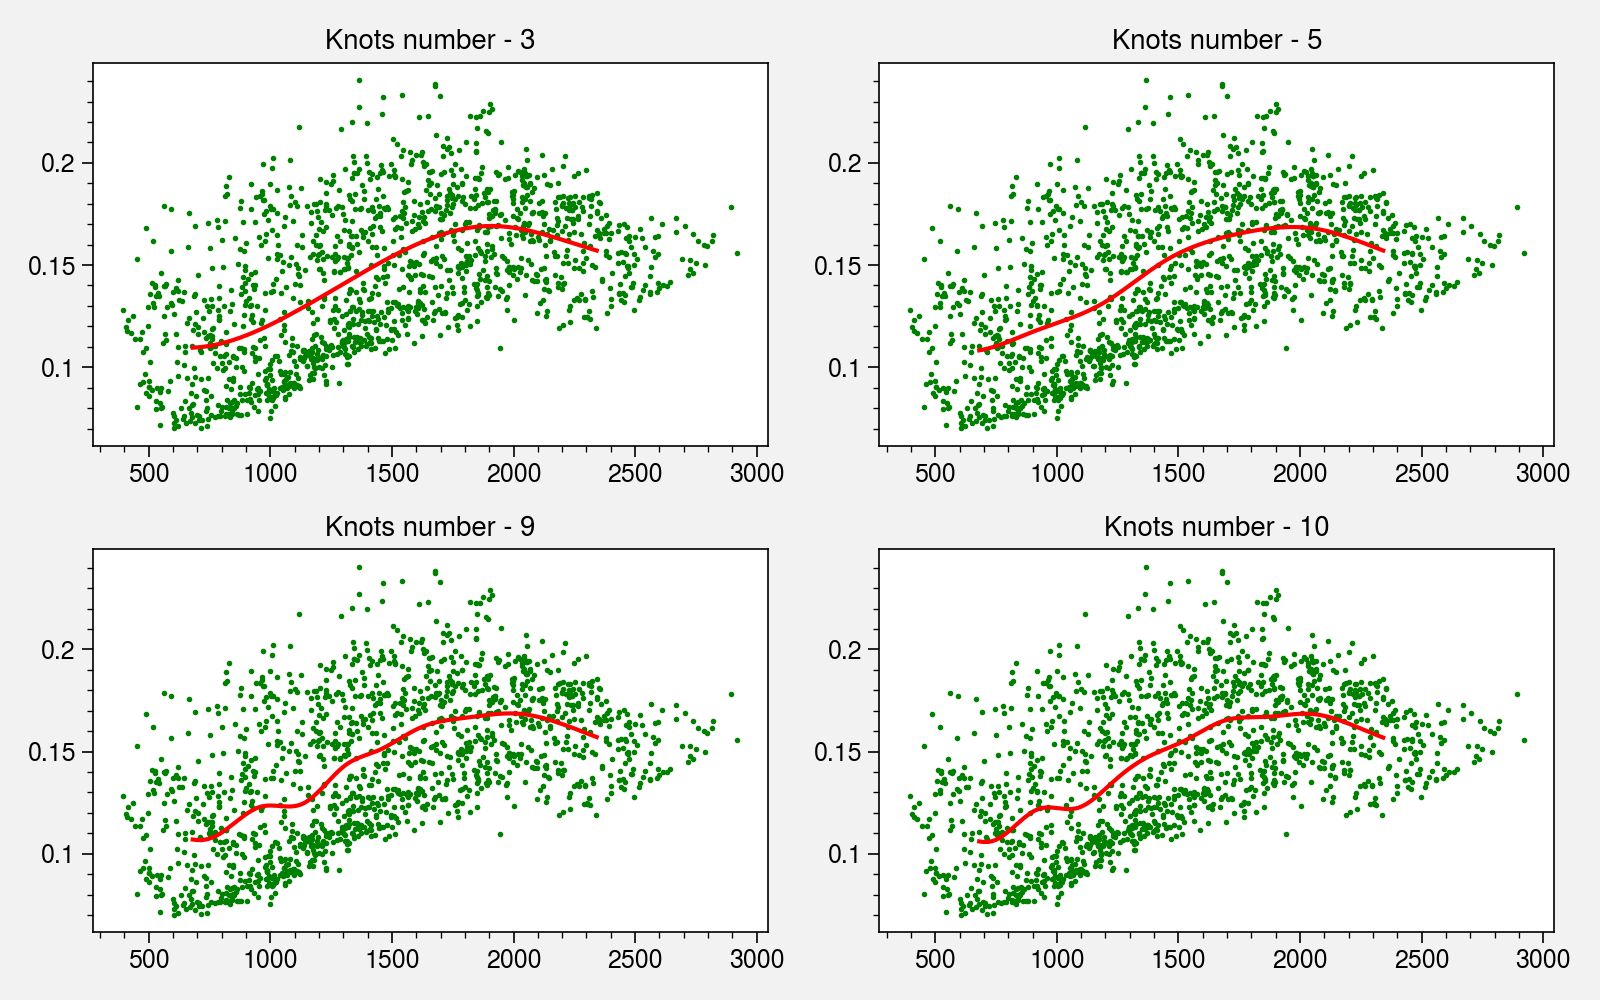

In [68]:
i=36

height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(alps_masks[4]))
vec_height = height[height.mask == False]

slope_T_MAM = 10*np.ma.masked_array(slope_T_periods_50[i,1], mask=np.invert(alps_masks[4]))
vec_slope_T_MAM = slope_T_MAM[slope_T_MAM.mask == False]
        
vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
vec_slope_T_MAM_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]


knots = [3, 5, 9, 10]
i = 0

ig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

for row in range(2):
    for col in range(2):
        ax[row][col].plot(vec_height_srt, vec_slope_T_MAM_srt, '.',c="g", markersize=2)
        yfit = spline(knots[i],vec_height_srt, vec_slope_T_MAM_srt)
        ax[row][col].plot(vec_height_srt[100:-100], yfit[100:-100], 'r')
        ax[row][col].set_title("Knots number - "+str(knots[i]))
        ax[row][col].grid()
        i=i+1
        
plt.tight_layout()        
plt.show()

In [69]:
vec_height_srt[np.argmax(yfit[100:-100])]

1875.8685

#### North Alps now

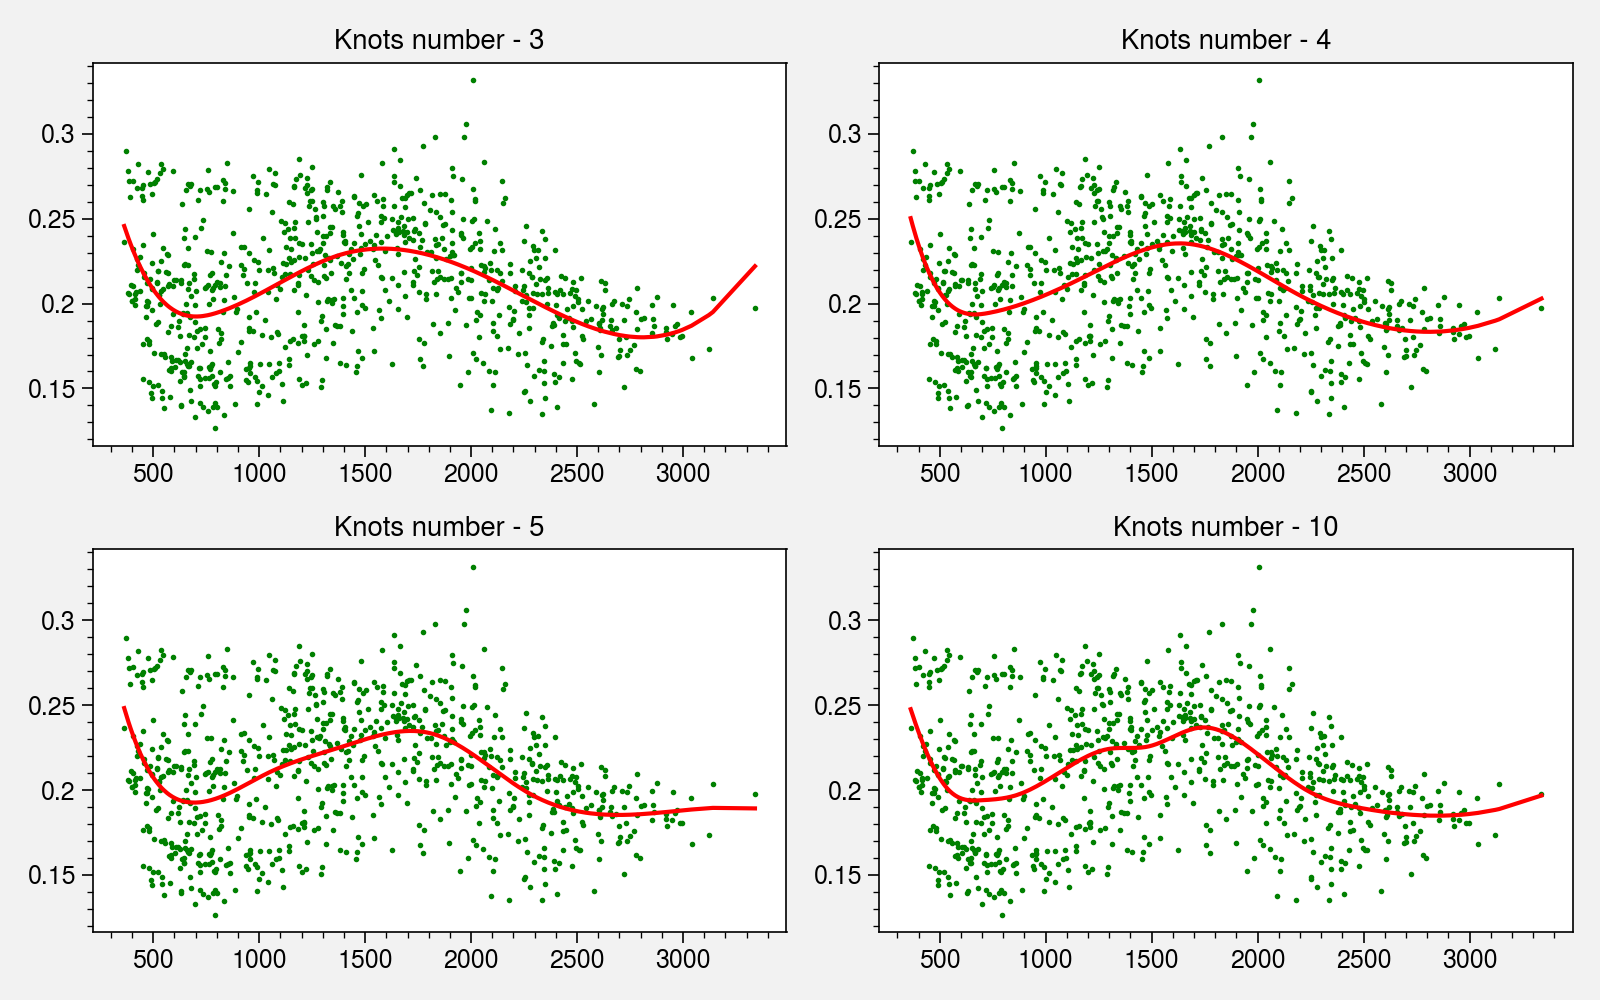

In [17]:
i=31

height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(alps_masks[2]))
vec_height = height[height.mask == False]

slope_T_MAM = 10*np.ma.masked_array(slope_T_periods_50[i,1], mask=np.invert(alps_masks[2]))
vec_slope_T_MAM = slope_T_MAM[slope_T_MAM.mask == False]
        
vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
vec_slope_T_MAM_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]


knots = [3, 4, 5, 10]
i = 0

ig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

for row in range(2):
    for col in range(2):
        ax[row][col].plot(vec_height_srt, vec_slope_T_MAM_srt, '.',c="g", markersize=2)
        yfit = spline(knots[i],vec_height_srt, vec_slope_T_MAM_srt)
        ax[row][col].plot(vec_height_srt, yfit, 'r')
        ax[row][col].set_title("Knots number - "+str(knots[i]))
        ax[row][col].grid()
        i=i+1
        
plt.tight_layout()        
plt.show()

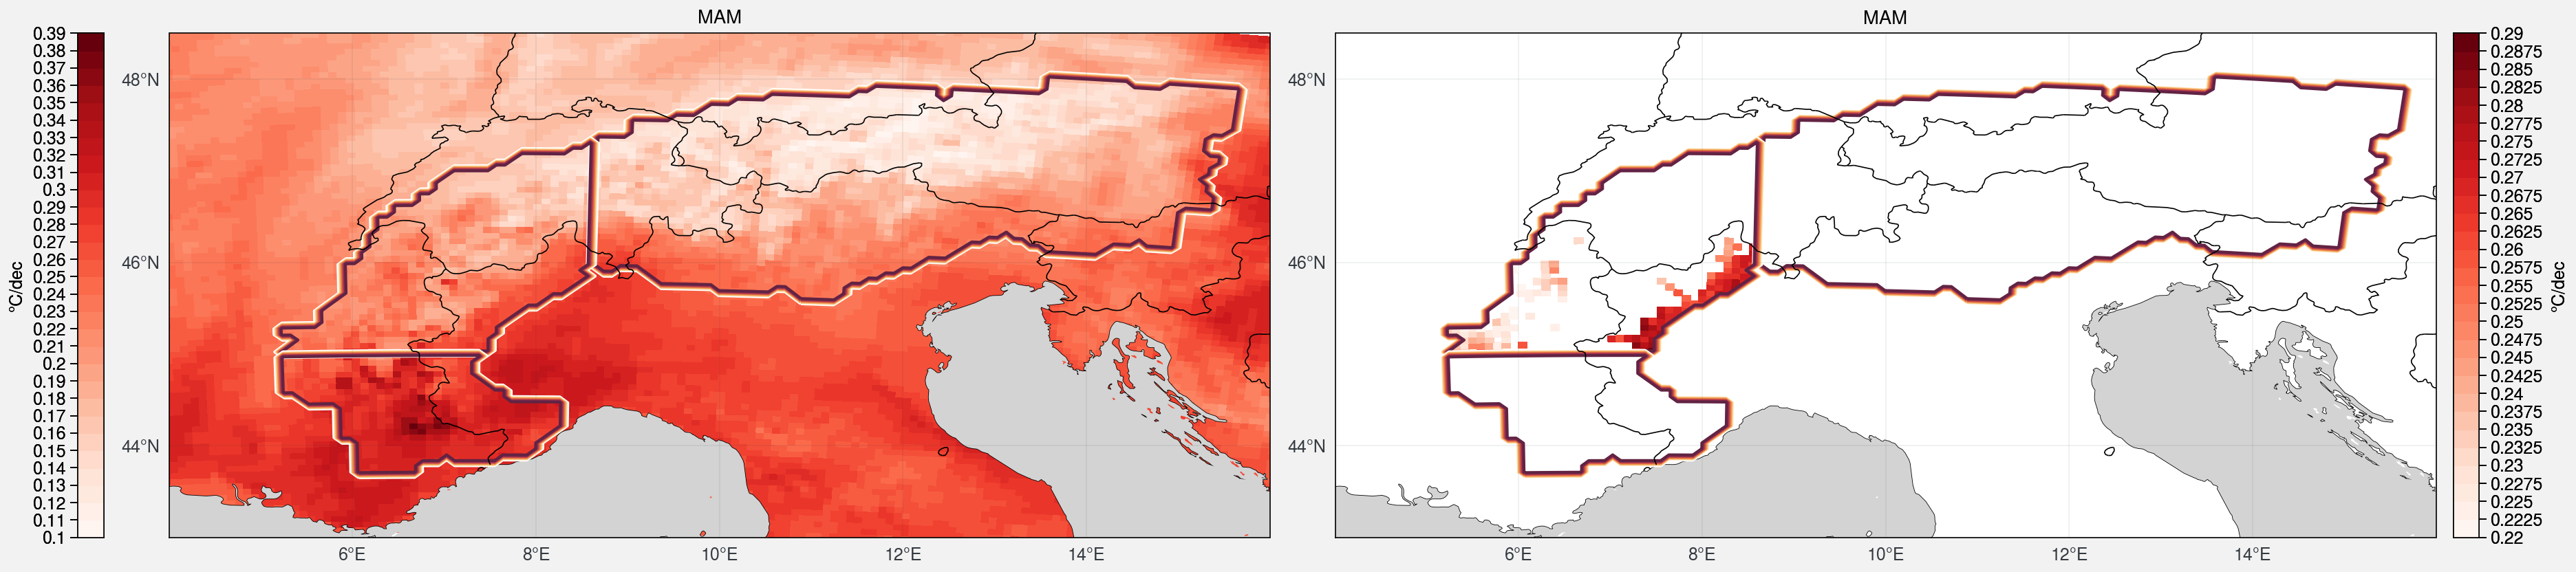

In [45]:
i=31

slope = 10*slope_T_periods_50[i]

north_alps_low = np.logical_and(north_alps,H<1300)
north_alps_low_hot = np.logical_and(north_alps_low,slope[1]>0.22)

northalps_slope_low_hot = np.ma.masked_array(slope[1], mask=np.invert(north_alps_low_hot))

f, axs = pplt.subplots(proj='cyl', ncols=2, axwidth=8)

m=axs[0].pcolormesh(lon, lat, slope[1], levels=33,cmap='Reds')
f.colorbar(m,label= '°C/dec',loc='l')
axs[0].contour(lon, lat,east_alps)
axs[0].contour(lon, lat,north_alps)
axs[0].contour(lon, lat,south_alps)
axs[0].format(**normal_format,title='MAM')
axs[0].format(ocean=True,oceancolor='lightgray',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])


m=axs[1].pcolormesh(lon, lat, northalps_slope_low_hot, levels=33,cmap='Reds')
f.colorbar(m,label= '°C/dec',loc='r')
axs[1].contour(lon, lat,east_alps)
axs[1].contour(lon, lat,north_alps)
axs[1].contour(lon, lat,south_alps)
axs[1].format(**normal_format,title='MAM')
axs[1].format(ocean=True,oceancolor='lightgray',reso='hi')#, latlim=[40.,51.],lonlim=[0.,20.])

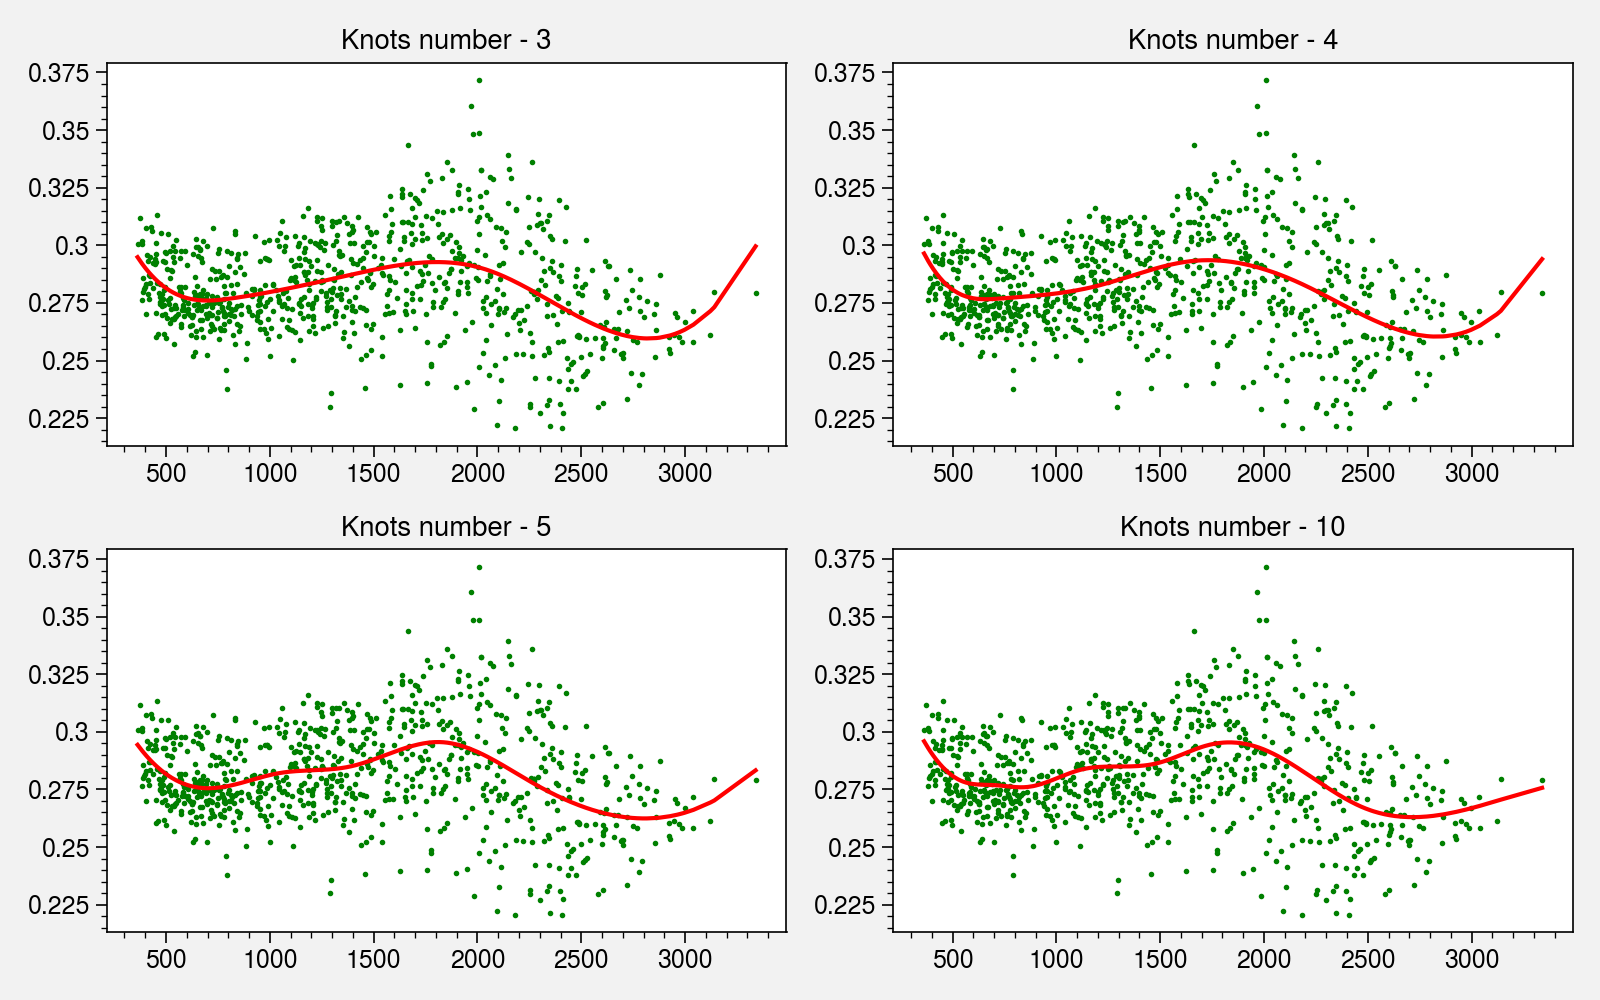

In [31]:
i=42

height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(alps_masks[2]))
vec_height = height[height.mask == False]

slope_T_MAM = 10*np.ma.masked_array(slope_T_periods_50[i,1], mask=np.invert(alps_masks[2]))
vec_slope_T_MAM = slope_T_MAM[slope_T_MAM.mask == False]
        
vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
vec_slope_T_MAM_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]


knots = [3, 4, 5, 10]
i = 0

ig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

for row in range(2):
    for col in range(2):
        ax[row][col].plot(vec_height_srt, vec_slope_T_MAM_srt, '.',c="g", markersize=2)
        yfit = spline(knots[i],vec_height_srt, vec_slope_T_MAM_srt)
        ax[row][col].plot(vec_height_srt, yfit, 'r')
        ax[row][col].set_title("Knots number - "+str(knots[i]))
        ax[row][col].grid()
        i=i+1
        
plt.tight_layout()        
plt.show()

### 30 y periods every 5 years

In [6]:
slope_T_periods_30 = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/slope_T_30yearperiods.npy')

In [7]:
slope_T_periods_30.shape

(110, 4, 91, 139)

In [18]:
slope_T_periods_30_redux = np.full((23,4,91,139),np.nan)

for i in range(22):
    slope_T_periods_30_redux[i] = slope_T_periods_30[5*i]

slope_T_periods_30_redux[-1] = slope_T_periods_30[-1]

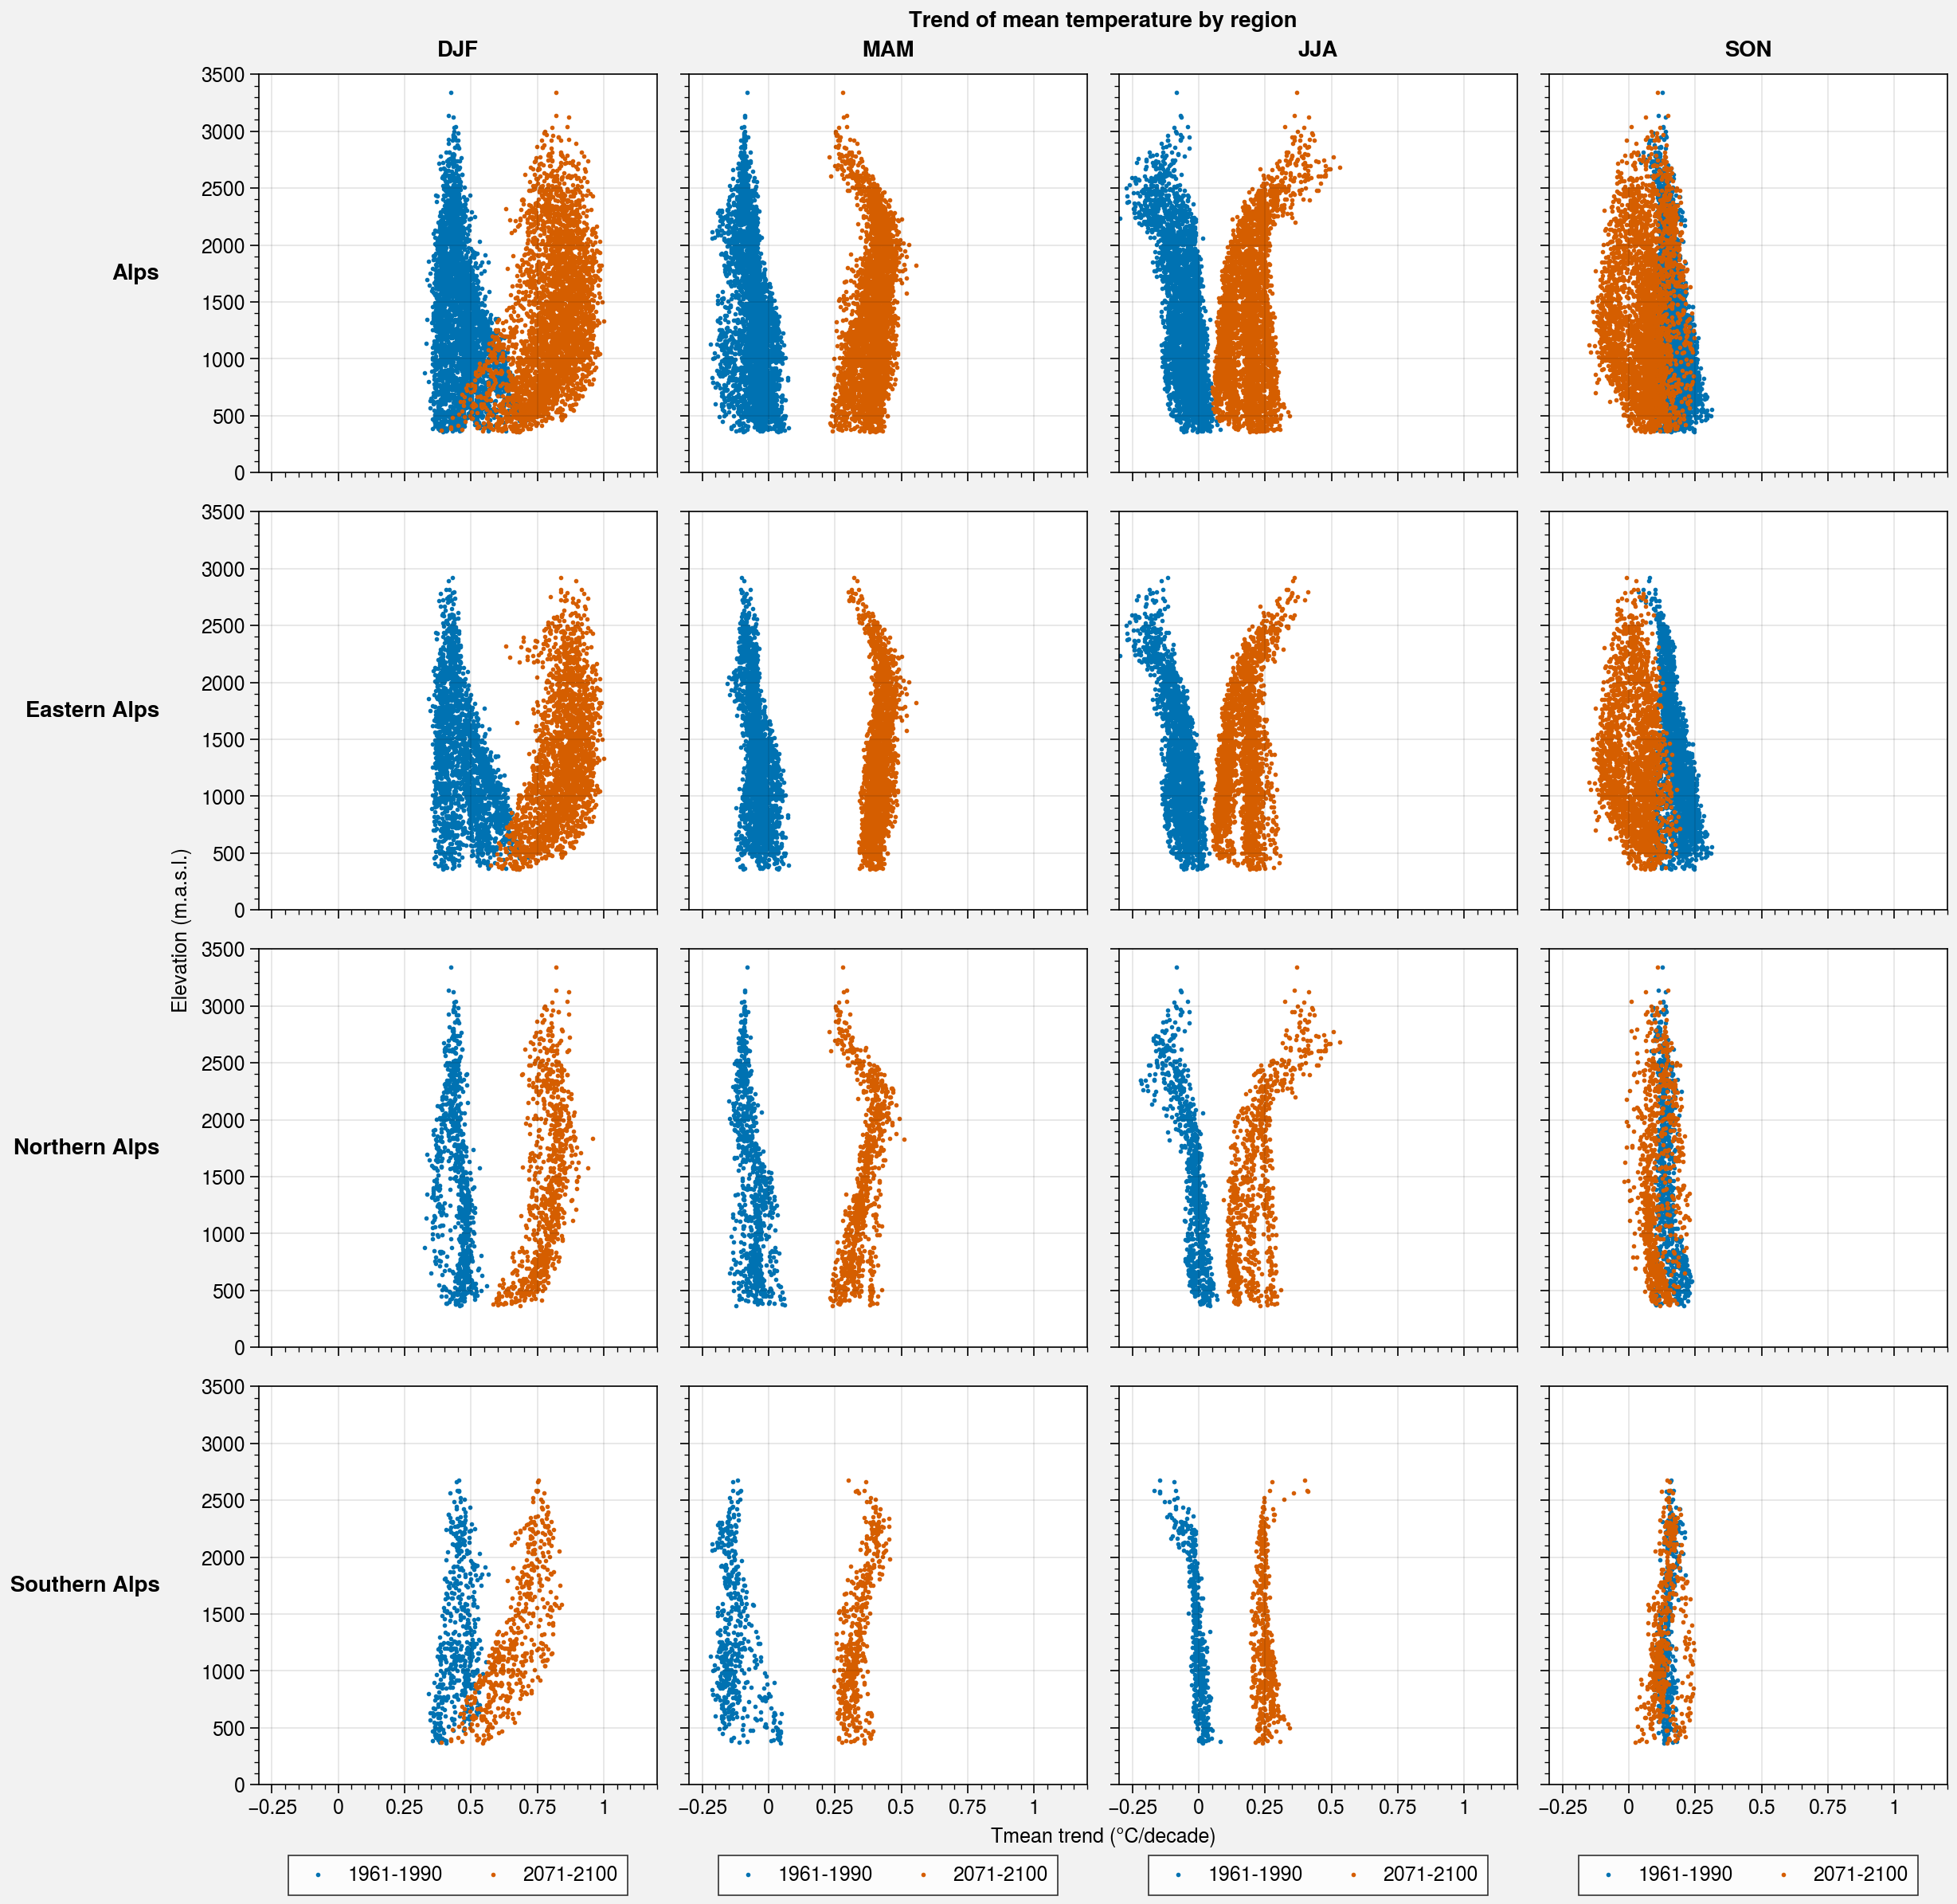

In [25]:
f, axs = pplt.subplots(ncols=4, nrows=4)
leg = ['1961-1990','2071-2100']



for i in range(4):
    slope_T_hist_alps = np.ma.masked_array(slope_T_periods_30_redux[0,i], mask=np.invert(alps))
    slope_T_hist_east_alps = np.ma.masked_array(slope_T_periods_30_redux[0,i], mask=np.invert(east_alps))
    slope_T_hist_north_alps = np.ma.masked_array(slope_T_periods_30_redux[0,i], mask=np.invert(north_alps))
    slope_T_hist_south_alps = np.ma.masked_array(slope_T_periods_30_redux[0,i], mask=np.invert(south_alps))
    slopes=[slope_T_hist_alps,slope_T_hist_east_alps,slope_T_hist_north_alps,slope_T_hist_south_alps]
    
    for j,slope in enumerate(slopes):
        ax = axs[i+4*j]
        blue_dot = ax.scatter(10*slope,ds.SH[jmin:jmax,imin:imax],s=2)
        
    
for i in range(4):
    slope_T_fut_alps = np.ma.masked_array(slope_T_periods_30_redux[-1,i], mask=np.invert(alps))
    slope_T_fut_east_alps = np.ma.masked_array(slope_T_periods_30_redux[-1,i], mask=np.invert(east_alps))
    slope_T_fut_north_alps = np.ma.masked_array(slope_T_periods_30_redux[-1,i], mask=np.invert(north_alps))
    slope_T_fut_south_alps = np.ma.masked_array(slope_T_periods_30_redux[-1,i], mask=np.invert(south_alps))
    slopes=[slope_T_fut_alps,slope_T_fut_east_alps,slope_T_fut_north_alps,slope_T_fut_south_alps]
    
    for j,slope in enumerate(slopes):
        ax = axs[i+4*j]
        orange_dot = ax.scatter(10*slope,ds.SH[jmin:jmax,imin:imax],s=2)
        ax.set_xlim((-0.3,1.2))
        ax.set_ylim((0.,3500))
        if(j==3):
            ax.legend([blue_dot,orange_dot],leg,loc='bottom')

axs.format(suptitle='Trend of mean temperature by region',collabels=['DJF','MAM','JJA', 'SON'],
           rowlabels=['Alps','Eastern Alps','Northern Alps','Southern Alps'],xlabel='Tmean trend (°C/decade)',ylabel='Elevation (m.a.s.l.)')

In [20]:

knot_numbers = 10
height_new = np.linspace(0, 1, knot_numbers+2)[1:-1]


height_max = np.full((4,23),np.nan) # 4 regions, 23 periods

alps_masks = [alps, east_alps, north_alps, south_alps]

for region in range(4):
    height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(alps_masks[region]))
    vec_height = height[height.mask == False]
    for i in range(23):
        slope_T_MAM = 10*np.ma.masked_array(slope_T_periods_30_redux[i,1], mask=np.invert(alps_masks[region]))
        vec_slope_T_MAM = slope_T_MAM[slope_T_MAM.mask == False]
        
        vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
        vec_slope_T_MAM_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
        
        q_knots = np.quantile(vec_height_srt, height_new)
        
        t,c,k = interpolate.splrep(vec_height_srt, vec_slope_T_MAM_srt, t=q_knots, s=1)
        yfit = interpolate.BSpline(t,c,k)(vec_height_srt)
        
        height_max[region,i] = vec_height_srt[np.argmax(yfit)]

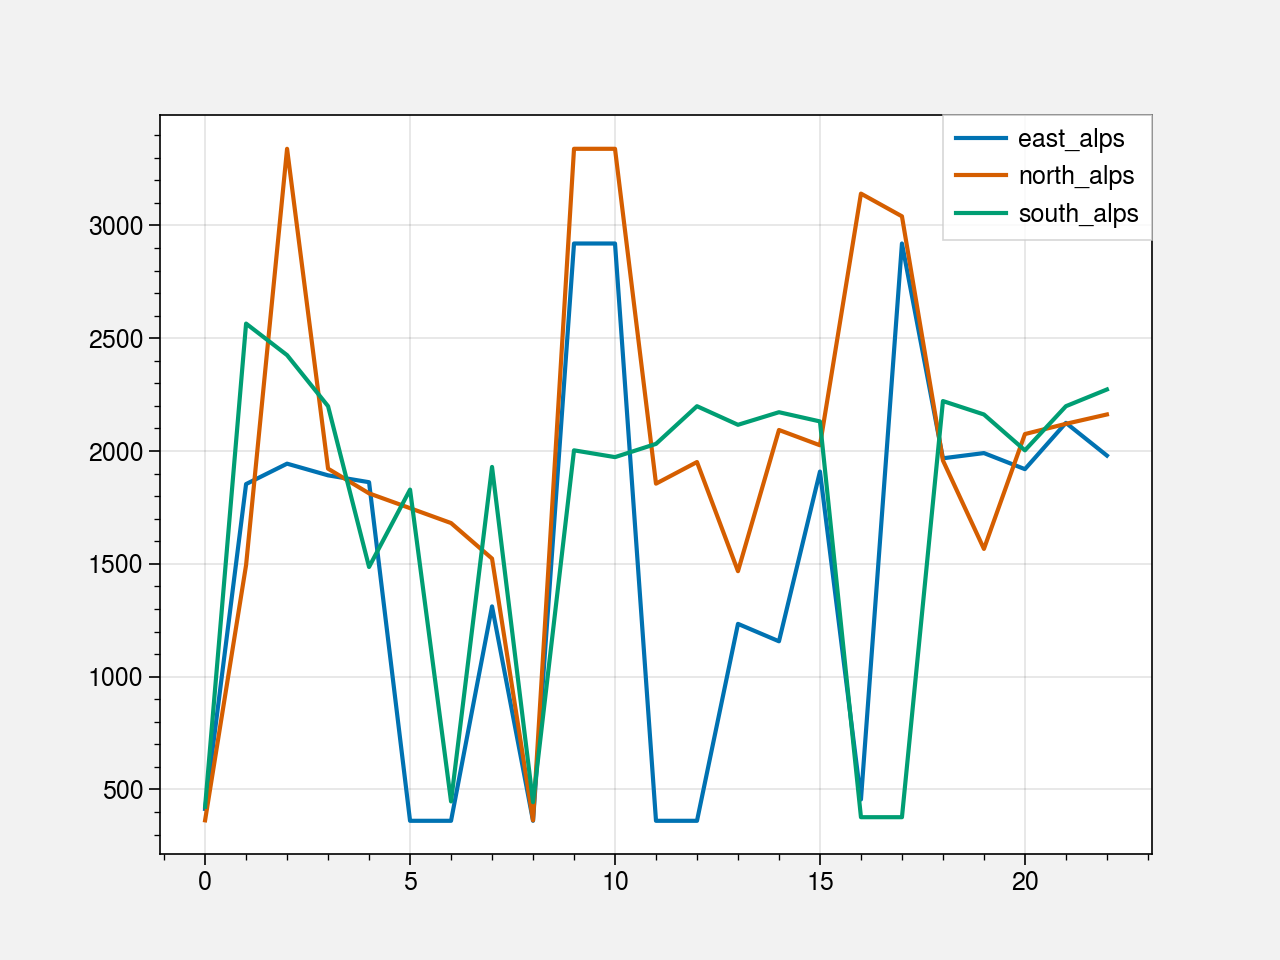

In [21]:
#plt.plot(height_max[0],label='alps')
plt.plot(height_max[1],label='east_alps')
plt.plot(height_max[2],label='north_alps')
plt.plot(height_max[3],label='south_alps')
#plt.scatter((21,32,40,55),(1500,1500,1500,1500))
#plt.xlim(25,55)
plt.legend()